# Table of Contents
 <p><div class="lev1"><a href="#Initialize-Environment"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev1"><a href="#Gather-all-data-sets"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gather all data sets</a></div><div class="lev2"><a href="#Stim-data"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Stim data</a></div><div class="lev2"><a href="#Baseline-Data"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Baseline Data</a></div><div class="lev1"><a href="#Measure-Global-Topology"><span class="toc-item-num">3&nbsp;&nbsp;</span>Measure Global Topology</a></div><div class="lev2"><a href="#Average-Node-Strength"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Average Node Strength</a></div><div class="lev3"><a href="#Generate-plots"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Generate plots</a></div><div class="lev4"><a href="#Effect-of-Stimulation-on-Average-Connectivity-Strength"><span class="toc-item-num">3.1.1.1&nbsp;&nbsp;</span>Effect of Stimulation on Average Connectivity Strength</a></div><div class="lev4"><a href="#Effect-of-Stimulation-Frequency-on-Topological-Reorganization"><span class="toc-item-num">3.1.1.2&nbsp;&nbsp;</span>Effect of Stimulation Frequency on Topological Reorganization</a></div><div class="lev4"><a href="#Effect-of-Stimulation-Amplitude-on-Topological-Reorganization"><span class="toc-item-num">3.1.1.3&nbsp;&nbsp;</span>Effect of Stimulation Amplitude on Topological Reorganization</a></div><div class="lev4"><a href="#Spatial-effects-of-stimulation-frequency-on-topological-reorganization"><span class="toc-item-num">3.1.1.4&nbsp;&nbsp;</span>Spatial effects of stimulation frequency on topological reorganization</a></div><div class="lev4"><a href="#Spatial-effects-of-stimulation-amplitude-on-topological-reorganization"><span class="toc-item-num">3.1.1.5&nbsp;&nbsp;</span>Spatial effects of stimulation amplitude on topological reorganization</a></div><div class="lev1"><a href="#Stimulation-node-topology"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stimulation node topology</a></div><div class="lev2"><a href="#Stim-Centrality"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Stim Centrality</a></div><div class="lev3"><a href="#Generate-plots"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Generate plots</a></div><div class="lev4"><a href="#Effect-of-Stim-Node-Strength-(Baseline)-on-Average-Connectivity-Change"><span class="toc-item-num">4.1.1.1&nbsp;&nbsp;</span>Effect of Stim Node Strength (Baseline) on Average Connectivity Change</a></div><div class="lev4"><a href="#Effect-of-Stim-Node-Strength-(Baseline)-on-Strongest-Node-Strength"><span class="toc-item-num">4.1.1.2&nbsp;&nbsp;</span>Effect of Stim Node Strength (Baseline) on Strongest Node Strength</a></div><div class="lev1"><a href="#Adjacency-Matrix"><span class="toc-item-num">5&nbsp;&nbsp;</span>Adjacency Matrix</a></div>

# Initialize Environment

In [136]:
try:
    %load_ext autoreload
    %autoreload 2
    %reset
except:
    print 'NOT IPYTHON'

from __future__ import division

import os
import sys
import glob
import time

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

sys.path.append('/home/akhambhati/JagHome/hoth_research/Echobase')
import Echobase

rcParams = Echobase.Plotting.fig_format.update_rcparams(rcParams)
rcParams['axes.titlesize'] = 10.0
rcParams['legend.fontsize'] = 10.0
rcParams['axes.labelsize'] = 10.0
rcParams['xtick.labelsize'] = 8.0
rcParams['ytick.labelsize'] = 8.0
rcParams['font.size'] = 5.0
rcParams.update(rcParams)

path_CoreData = '/data/jag/akhambhati/Remotes/CORE.RAM_Stim'
path_PeriphData = '/home/akhambhati/Procd_Data/RSRCH.RAM_Stim'
path_InpData = path_PeriphData + '/e01-FuncNetw'
path_InpData_Baseline = path_PeriphData + '/e01-FuncNetw-Baseline'
path_ExpData = path_PeriphData + '/e02-GlobalTopo'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Gather all data sets

## Stim data

In [96]:
path_list = glob.glob('{}/Adjacency.*.npz'.format(path_InpData))
#path_list = np.random.permutation(path_list)[:100]

subj_dict = {}
meta_dict = {}
for pth in path_list:    
    full_file = pth.split('/')[-1]   
    
    subj_id = full_file.split('.')[1]
    freq_id = full_file.split('.')[2]
    amp_id = full_file.split('.')[3]
    trial_id = full_file.split('.')[4]
    
    if not subj_id in subj_dict.keys():
        subj_dict[subj_id] = {}        
    if not freq_id in subj_dict[subj_id].keys():
        subj_dict[subj_id][freq_id] = {}
    if not amp_id in subj_dict[subj_id][freq_id].keys():
        subj_dict[subj_id][freq_id][amp_id] = {}
    if not trial_id in subj_dict[subj_id][freq_id][amp_id].keys():
        subj_dict[subj_id][freq_id][amp_id][trial_id] = {'adj_path': pth,
                                                         'raw_name': '{}.{}.{}.{}'.format(subj_id,
                                                                                          freq_id,
                                                                                          amp_id,
                                                                                          trial_id)}
        
    if not subj_id in meta_dict.keys():
        meta_dict[subj_id] = {}
        
        # Load Channel Info
        ch_path = '{}/Channel_Info/{}.mat'.format(path_CoreData, subj_id)
        df_ch = io.loadmat(ch_path)
        if len(df_ch['stim_ind_ofgoodch'][0,:]) == 0:
            continue
        
        n_node = df_ch['good_channels'].shape[1]
                
        # Find good xyzcoords
        xyzcoords = []        
        xyzcoords_ch_num = np.array(map(int, df_ch['xyzcoords_select'][:, 0]))
        for ch_num in df_ch['good_channels'][0]:
            ch_ix = np.flatnonzero(xyzcoords_ch_num == int(ch_num))
            
            if len(ch_ix) != 1:
                xyzcoords.append(np.nan*np.zeros(3))
            else:
                xyzcoords.append(df_ch['xyzcoords_select'][ch_ix, 1:].reshape(-1))
        xyzcoords = np.array(xyzcoords)

        
        # Construct distance matrix
        dist_matr = np.zeros((n_node, n_node))
        triu_ix, triu_iy = np.triu_indices(n_node, k=1)
        for ix, iy in zip(triu_ix, triu_iy):
            dist_matr[ix, iy] = np.sqrt(np.sum((xyzcoords[ix]-xyzcoords[iy])**2))
        dist_matr += dist_matr.T
        
        # Identify stim node
        meta_dict[subj_id]['stim_nodes'] = df_ch['stim_ind_ofgoodch'][0,:]-1
        meta_dict[subj_id]['dist_to_stim_one'] = dist_matr[meta_dict[subj_id]['stim_nodes'][0], :]
        meta_dict[subj_id]['dist_to_stim_one'] = np.delete(meta_dict[subj_id]['dist_to_stim_one'],
                                                           (meta_dict[subj_id]['stim_nodes'][0],
                                                            meta_dict[subj_id]['stim_nodes'][1]))
        meta_dict[subj_id]['dist_to_stim_two'] = dist_matr[meta_dict[subj_id]['stim_nodes'][1], :]        
        meta_dict[subj_id]['dist_to_stim_two'] = np.delete(meta_dict[subj_id]['dist_to_stim_two'],
                                                           (meta_dict[subj_id]['stim_nodes'][0],
                                                            meta_dict[subj_id]['stim_nodes'][1]))
        
        dist_matr = np.delete(dist_matr, (meta_dict[subj_id]['stim_nodes'][0],
                                          meta_dict[subj_id]['stim_nodes'][1]),
                              axis=0)
        dist_matr = np.delete(dist_matr, (meta_dict[subj_id]['stim_nodes'][0],
                                          meta_dict[subj_id]['stim_nodes'][1]),
                              axis=1)
        meta_dict[subj_id]['dist_matr'] = dist_matr        

print('There are {} processed trials to analyze.'.format(len(path_list)))

There are 57694 processed trials to analyze.


## Baseline Data

In [97]:
path_list_base = glob.glob('{}/Adjacency.*.npz'.format(path_InpData_Baseline))

subj_dict_baseline = {}
for pth in path_list_base:    
    full_file = pth.split('/')[-1]   
    
    subj_id = full_file.split('.')[1]
    trial_id = full_file.split('.')[2]
    
    if not subj_id in subj_dict_baseline.keys():
        subj_dict_baseline[subj_id] = {}        
    if not trial_id in subj_dict_baseline[subj_id].keys():
        subj_dict_baseline[subj_id][trial_id] = {'adj_path': pth,
                                                 'raw_name': '{}.{}'.format(subj_id,
                                                                            trial_id)}

# Measure Global Topology

## Average Node Strength

In [ ]:
data_table_1 = {'Subject_ID': [],
                'Stim_Freq': [],
                'Stim_Amp': [],
                'Stim_Trial': [],
                
                'Pre_Adj_AlphaTheta_AvgNodeStr': [],
                'Pre_Adj_Beta_AvgNodeStr': [],
                'Pre_Adj_LowGamma_AvgNodeStr': [],
                'Pre_Adj_HighGamma_AvgNodeStr': [],    
                
                'Post_Adj_AlphaTheta_AvgNodeStr': [],
                'Post_Adj_Beta_AvgNodeStr': [],
                'Post_Adj_LowGamma_AvgNodeStr': [],
                'Post_Adj_HighGamma_AvgNodeStr': [],
                
                'Delta_Adj_AlphaTheta_AvgNodeStr': [],
                'Delta_Adj_Beta_AvgNodeStr': [],
                'Delta_Adj_LowGamma_AvgNodeStr': [],
                'Delta_Adj_HighGamma_AvgNodeStr': [],

                'Delta_Pos_NodeStr_AlphaTheta': [],
                'Delta_Pos_NodeStr_Beta': [],
                'Delta_Pos_NodeStr_LowGamma': [],
                'Delta_Pos_NodeStr_HighGamma': [],

                'Delta_Neg_NodeStr_AlphaTheta': [],
                'Delta_Neg_NodeStr_Beta': [],
                'Delta_Neg_NodeStr_LowGamma': [],
                'Delta_Neg_NodeStr_HighGamma': [],                
                
                'Dist_S1_Delta_Pos_NodeStr_AlphaTheta': [],
                'Dist_S1_Delta_Pos_NodeStr_Beta': [],
                'Dist_S1_Delta_Pos_NodeStr_LowGamma': [],
                'Dist_S1_Delta_Pos_NodeStr_HighGamma': [],
                
                'Dist_S1_Delta_Neg_NodeStr_AlphaTheta': [],
                'Dist_S1_Delta_Neg_NodeStr_Beta': [],
                'Dist_S1_Delta_Neg_NodeStr_LowGamma': [],
                'Dist_S1_Delta_Neg_NodeStr_HighGamma': []}

for subj_ii, subj_id in enumerate(subj_dict.keys()):
    print('Subject: {} ({} of {})'.format(subj_id, subj_ii+1, len(subj_dict.keys())))
    
    for freq_id in subj_dict[subj_id].keys():
        for amp_id in subj_dict[subj_id][freq_id].keys():
            for trial_id in subj_dict[subj_id][freq_id][amp_id].keys():   
                
                # Format freq_id, amp_id
                freq_int = int(freq_id.split('_')[1])
                amp_int = amp_id.split('Amp_')[1].split('_')
                if len(amp_int) == 2:
                    amp_int = float('{}.{}'.format(amp_int[0], amp_int[1]))
                else:
                    amp_int = float(amp_int[0])
                                    
                # Load Adjacency
                adj_path = subj_dict[subj_id][freq_id][amp_id][trial_id]['adj_path']
                df = np.load(adj_path)
                adj = df['adj'].item()                
                                
                # Grab adjacency matrices
                adj_pre_alphatheta = adj['Pre_Stim']['AlphaTheta']
                adj_pre_beta = adj['Pre_Stim']['Beta']
                adj_pre_lowgamma = adj['Pre_Stim']['LowGamma']
                adj_pre_highgamma = adj['Pre_Stim']['HighGamma']                

                adj_post_alphatheta = adj['Post_Stim']['AlphaTheta']
                adj_post_beta = adj['Post_Stim']['Beta']
                adj_post_lowgamma = adj['Post_Stim']['LowGamma']
                adj_post_highgamma = adj['Post_Stim']['HighGamma'] 
                
                adj_delta_alphatheta = adj_post_alphatheta-adj_pre_alphatheta
                adj_delta_beta = adj_post_beta-adj_pre_beta
                adj_delta_lowgamma = adj_post_lowgamma-adj_pre_lowgamma
                adj_delta_highgamma = adj_post_highgamma-adj_pre_highgamma
                
                # Compute node strengths
                ns_pre_alphatheta = np.mean(adj_pre_alphatheta, axis=0)
                ns_pre_beta = np.mean(adj_pre_beta, axis=0)
                ns_pre_lowgamma = np.mean(adj_pre_lowgamma, axis=0)
                ns_pre_highgamma = np.mean(adj_pre_highgamma, axis=0)

                ns_post_alphatheta = np.mean(adj_post_alphatheta, axis=0)
                ns_post_beta = np.mean(adj_post_beta, axis=0)
                ns_post_lowgamma = np.mean(adj_post_lowgamma, axis=0)
                ns_post_highgamma = np.mean(adj_post_highgamma, axis=0)
                
                ns_delta_alphatheta = np.mean(adj_delta_alphatheta, axis=0)
                ns_delta_beta = np.mean(adj_delta_beta, axis=0)
                ns_delta_lowgamma = np.mean(adj_delta_lowgamma, axis=0)
                ns_delta_highgamma = np.mean(adj_delta_highgamma, axis=0)
                
                delta_pos_ns_alphatheta = np.max(ns_delta_alphatheta)
                delta_pos_ns_beta = np.max(ns_delta_beta)
                delta_pos_ns_lowgamma = np.max(ns_delta_lowgamma)
                delta_pos_ns_highgamma = np.max(ns_delta_highgamma)                

                delta_neg_ns_alphatheta = np.min(ns_delta_alphatheta)
                delta_neg_ns_beta = np.min(ns_delta_beta)
                delta_neg_ns_lowgamma = np.min(ns_delta_lowgamma)
                delta_neg_ns_highgamma = np.min(ns_delta_highgamma)                                
                
                # Get upper triangle
                n_node = adj_pre_alphatheta.shape[0]
                triu_ix, triu_iy = np.triu_indices(n_node, k=1)

                # Compute mean node strength
                pre_alphatheta = np.mean(ns_pre_alphatheta)
                pre_beta = np.mean(ns_pre_beta)
                pre_lowgamma = np.mean(ns_pre_lowgamma)
                pre_highgamma = np.mean(ns_pre_highgamma)

                post_alphatheta = np.mean(ns_post_alphatheta)
                post_beta = np.mean(ns_post_beta)
                post_lowgamma = np.mean(ns_post_lowgamma)
                post_highgamma = np.mean(ns_post_highgamma)
                
                # Compute mean change in node strength 
                delta_alphatheta = np.mean(ns_delta_alphatheta)
                delta_beta = np.mean(ns_delta_beta)
                delta_lowgamma = np.mean(ns_delta_lowgamma)
                delta_highgamma = np.mean(ns_delta_highgamma)
                                
                # Relationship between change in node strength and distance from stimulation site (S1)    
                try:                
                    dist_to_S1 = meta_dict[subj_id]['dist_to_stim_one']
                    good_dist_ix = np.flatnonzero(~np.isnan(dist_to_S1))

                    dist_s1_delta_pos_ns_AlphaTheta = dist_to_S1[good_dist_ix][np.argmax(ns_delta_alphatheta[good_dist_ix])]
                    dist_s1_delta_pos_ns_Beta = dist_to_S1[good_dist_ix][np.argmax(ns_delta_beta[good_dist_ix])]
                    dist_s1_delta_pos_ns_LowGamma = dist_to_S1[good_dist_ix][np.argmax(ns_delta_lowgamma[good_dist_ix])]
                    dist_s1_delta_pos_ns_HighGamma = dist_to_S1[good_dist_ix][np.argmax(ns_delta_highgamma[good_dist_ix])]
                    
                    dist_s1_delta_neg_ns_AlphaTheta = dist_to_S1[good_dist_ix][np.argmin(ns_delta_alphatheta[good_dist_ix])]
                    dist_s1_delta_neg_ns_Beta = dist_to_S1[good_dist_ix][np.argmin(ns_delta_beta[good_dist_ix])]               
                    dist_s1_delta_neg_ns_LowGamma = dist_to_S1[good_dist_ix][np.argmin(ns_delta_lowgamma[good_dist_ix])]
                    dist_s1_delta_neg_ns_HighGamma = dist_to_S1[good_dist_ix][np.argmin(ns_delta_highgamma[good_dist_ix])]
                except:
                    dist_s1_delta_pos_ns_AlphaTheta = np.nan
                    dist_s1_delta_pos_ns_Beta = np.nan
                    dist_s1_delta_pos_ns_LowGamma = np.nan
                    dist_s1_delta_pos_ns_HighGamma = np.nan
                    
                    dist_s1_delta_neg_ns_AlphaTheta = np.nan
                    dist_s1_delta_neg_ns_Beta = np.nan
                    dist_s1_delta_neg_ns_LowGamma = np.nan
                    dist_s1_delta_neg_ns_HighGamma = np.nan
                                                                                       
                # Add to Data Table 1
                df.close()
                data_table_1['Subject_ID'].append(subj_id)
                data_table_1['Stim_Freq'].append(freq_int)
                data_table_1['Stim_Amp'].append(amp_int)
                data_table_1['Stim_Trial'].append(trial_id)
                
                data_table_1['Pre_Adj_AlphaTheta_AvgNodeStr'].append(pre_alphatheta)
                data_table_1['Pre_Adj_Beta_AvgNodeStr'].append(pre_beta)
                data_table_1['Pre_Adj_LowGamma_AvgNodeStr'].append(pre_lowgamma)
                data_table_1['Pre_Adj_HighGamma_AvgNodeStr'].append(pre_highgamma)
                
                data_table_1['Post_Adj_AlphaTheta_AvgNodeStr'].append(post_alphatheta)
                data_table_1['Post_Adj_Beta_AvgNodeStr'].append(post_beta)
                data_table_1['Post_Adj_LowGamma_AvgNodeStr'].append(post_lowgamma)
                data_table_1['Post_Adj_HighGamma_AvgNodeStr'].append(post_alphatheta)
                
                data_table_1['Delta_Adj_AlphaTheta_AvgNodeStr'].append(delta_alphatheta)
                data_table_1['Delta_Adj_Beta_AvgNodeStr'].append(delta_beta)
                data_table_1['Delta_Adj_LowGamma_AvgNodeStr'].append(delta_lowgamma)
                data_table_1['Delta_Adj_HighGamma_AvgNodeStr'].append(delta_highgamma)   

                data_table_1['Delta_Pos_NodeStr_AlphaTheta'].append(delta_pos_ns_alphatheta)
                data_table_1['Delta_Pos_NodeStr_Beta'].append(delta_pos_ns_beta)
                data_table_1['Delta_Pos_NodeStr_LowGamma'].append(delta_pos_ns_lowgamma)
                data_table_1['Delta_Pos_NodeStr_HighGamma'].append(delta_pos_ns_highgamma)                   

                data_table_1['Delta_Neg_NodeStr_AlphaTheta'].append(delta_neg_ns_alphatheta)
                data_table_1['Delta_Neg_NodeStr_Beta'].append(delta_neg_ns_beta)
                data_table_1['Delta_Neg_NodeStr_LowGamma'].append(delta_neg_ns_lowgamma)
                data_table_1['Delta_Neg_NodeStr_HighGamma'].append(delta_neg_ns_highgamma)                   
                
                data_table_1['Dist_S1_Delta_Pos_NodeStr_AlphaTheta'].append(dist_s1_delta_pos_ns_AlphaTheta)
                data_table_1['Dist_S1_Delta_Pos_NodeStr_Beta'].append(dist_s1_delta_pos_ns_Beta)
                data_table_1['Dist_S1_Delta_Pos_NodeStr_LowGamma'].append(dist_s1_delta_pos_ns_LowGamma)
                data_table_1['Dist_S1_Delta_Pos_NodeStr_HighGamma'].append(dist_s1_delta_pos_ns_HighGamma)   

                data_table_1['Dist_S1_Delta_Neg_NodeStr_AlphaTheta'].append(dist_s1_delta_neg_ns_AlphaTheta)
                data_table_1['Dist_S1_Delta_Neg_NodeStr_Beta'].append(dist_s1_delta_neg_ns_Beta)
                data_table_1['Dist_S1_Delta_Neg_NodeStr_LowGamma'].append(dist_s1_delta_neg_ns_LowGamma)
                data_table_1['Dist_S1_Delta_Neg_NodeStr_HighGamma'].append(dist_s1_delta_neg_ns_HighGamma)   
                
# Save Data Tables for R-stats
df = pd.DataFrame(data_table_1, columns=data_table_1.keys())
df.to_csv('./e02-Stats/average_node_strength.csv')

Subject: R1150J (1 of 57)
Subject: R1084T (2 of 57)
Subject: R1093J_1 (3 of 57)
Subject: R1121M (4 of 57)
Subject: R1131M (5 of 57)
Subject: R1086M (6 of 57)
Subject: R1070T (7 of 57)
Subject: R1068J (8 of 57)
Subject: R1077T (9 of 57)
Subject: R1064E_1 (10 of 57)
Subject: R1052E_1 (11 of 57)
Subject: R1125T (12 of 57)
Subject: R1066P (13 of 57)
Subject: R1104D (14 of 57)
Subject: R1112M (15 of 57)
Subject: R1062J (16 of 57)
Subject: R1134T (17 of 57)
Subject: R1114C (18 of 57)
Subject: R1100D (19 of 57)
Subject: R1044J (20 of 57)
Subject: R1025P (21 of 57)
Subject: R1050M (22 of 57)
Subject: R1096E (23 of 57)
Subject: R1060M (24 of 57)
Subject: R1122E (25 of 57)
Subject: R1120E (26 of 57)
Subject: R1064E (27 of 57)
Subject: R1074M (28 of 57)
Subject: R1030J (29 of 57)
Subject: R1067P (30 of 57)
Subject: R1108J (31 of 57)
Subject: R1130M (32 of 57)
Subject: R1059J_2 (33 of 57)
Subject: R1034D (34 of 57)
Subject: R1059J_1 (35 of 57)
Subject: R1081J (36 of 57)
Subject: R1054J (37 of 57)


### Generate plots

#### Effect of Stimulation on Average Connectivity Strength
The average connection strength before stimulation predicts the average connection strength after. There is a "conservation of connectivity" for Alpha/Theta, Beta, and Low Gamma coherence networks. There is a reduction in average connection strength for high gamma connectivity. 

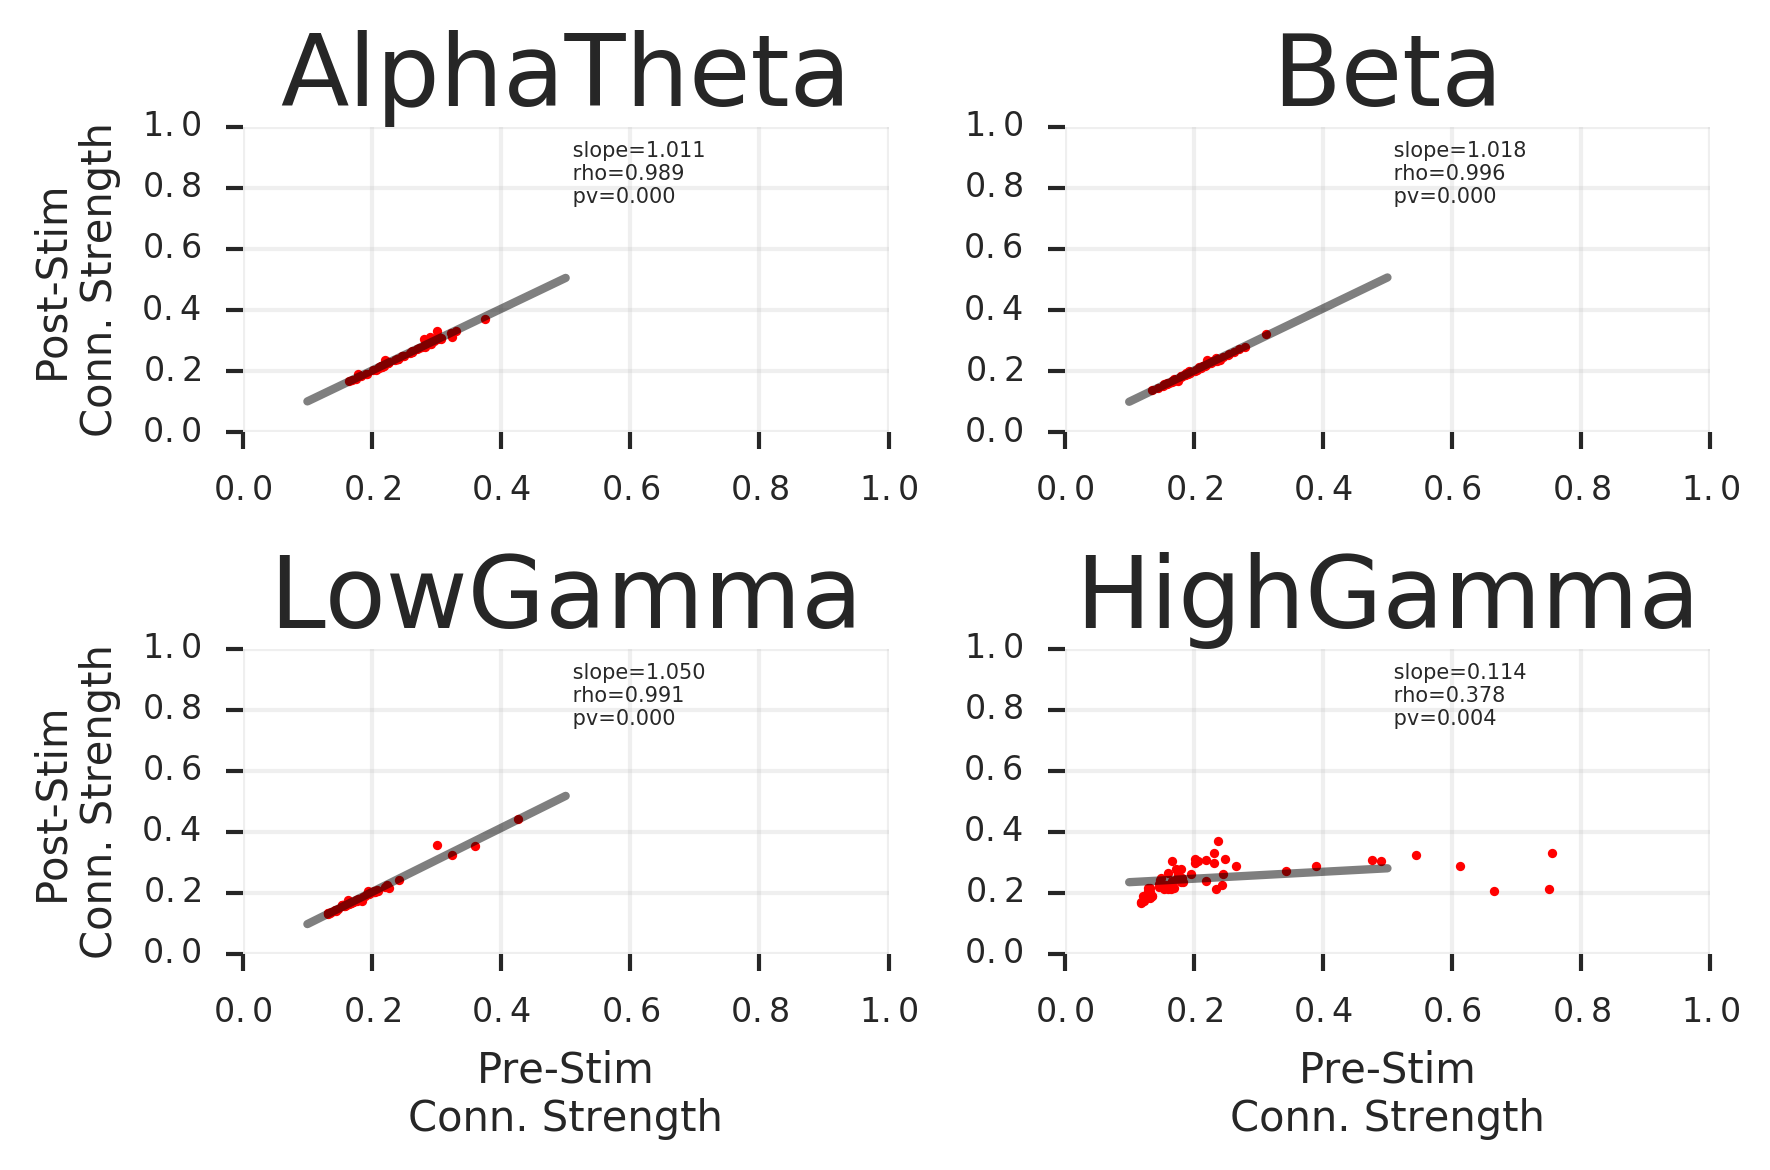

In [116]:
df = pd.read_csv('./e02-Stats/average_node_strength.csv')

%matplotlib inline

plt.figure()

sel_subj = df.groupby([df['Subject_ID']]).mean().unstack()
adj_freqs = [('Pre_Adj_AlphaTheta_AvgNodeStr', 'Post_Adj_AlphaTheta_AvgNodeStr'),
             ('Pre_Adj_Beta_AvgNodeStr', 'Post_Adj_Beta_AvgNodeStr'),
             ('Pre_Adj_LowGamma_AvgNodeStr', 'Post_Adj_LowGamma_AvgNodeStr'),
             ('Pre_Adj_HighGamma_AvgNodeStr', 'Post_Adj_HighGamma_AvgNodeStr')]
for ii, afreq in enumerate(adj_freqs):
    ax = plt.subplot(2, 2, ii+1)
    
    # Regression
    slope, yint, rho, pv, stderr = stats.linregress(sel_subj[afreq[0]], sel_subj[afreq[1]])
    ax.plot([0.1, 0.5], slope*np.array([0.1, 0.5])+yint, 'k', alpha=0.5)    
    ax.scatter(sel_subj[afreq[0]], sel_subj[afreq[1]], s=5,
               color='r', lw=0)
    
    ax.text(0.5, 0.75, ' slope=%0.3f\n rho=%0.3f\n pv=%0.3f' % (slope, rho, pv), fontsize=5.0)
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    if ii in [0, 2]:
        ax.set_ylabel('Post-Stim\nConn. Strength')
    if ii in [2, 3]:
        ax.set_xlabel('Pre-Stim\nConn. Strength')      
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(afreq[0].split('_')[2])

plt.savefig('./e02-Figures/Pre_Conn_Strength-Post_Conn_Strength.png')
plt.show()

#### Effect of Stimulation Frequency on Topological Reorganization
Stimulation reorganizes frequency-dependent network topology. We track network reorganization by computing the Pearson correlation between pre-stim/post-stim configuration vector. Correlation values closer to +1 imply greater configuration similarity, and less reorganiztion, and values closer to -1 imply lower configuration similarity, and greater reorganization.

F=71.2497, pv=0.0000
Ttest_relResult(statistic=6.6694748032223359, pvalue=2.5902874245237594e-11)
Ttest_relResult(statistic=4.3039964271776245, pvalue=1.680203973853484e-05)
Ttest_relResult(statistic=13.060151394342952, pvalue=6.3167099686419011e-39)
Ttest_relResult(statistic=-2.4594467058972791, pvalue=0.013918047872117208)
Ttest_relResult(statistic=9.2458215855093631, pvalue=2.4112079174026941e-20)
Ttest_relResult(statistic=13.005617031269427, pvalue=1.2883872903784541e-38)


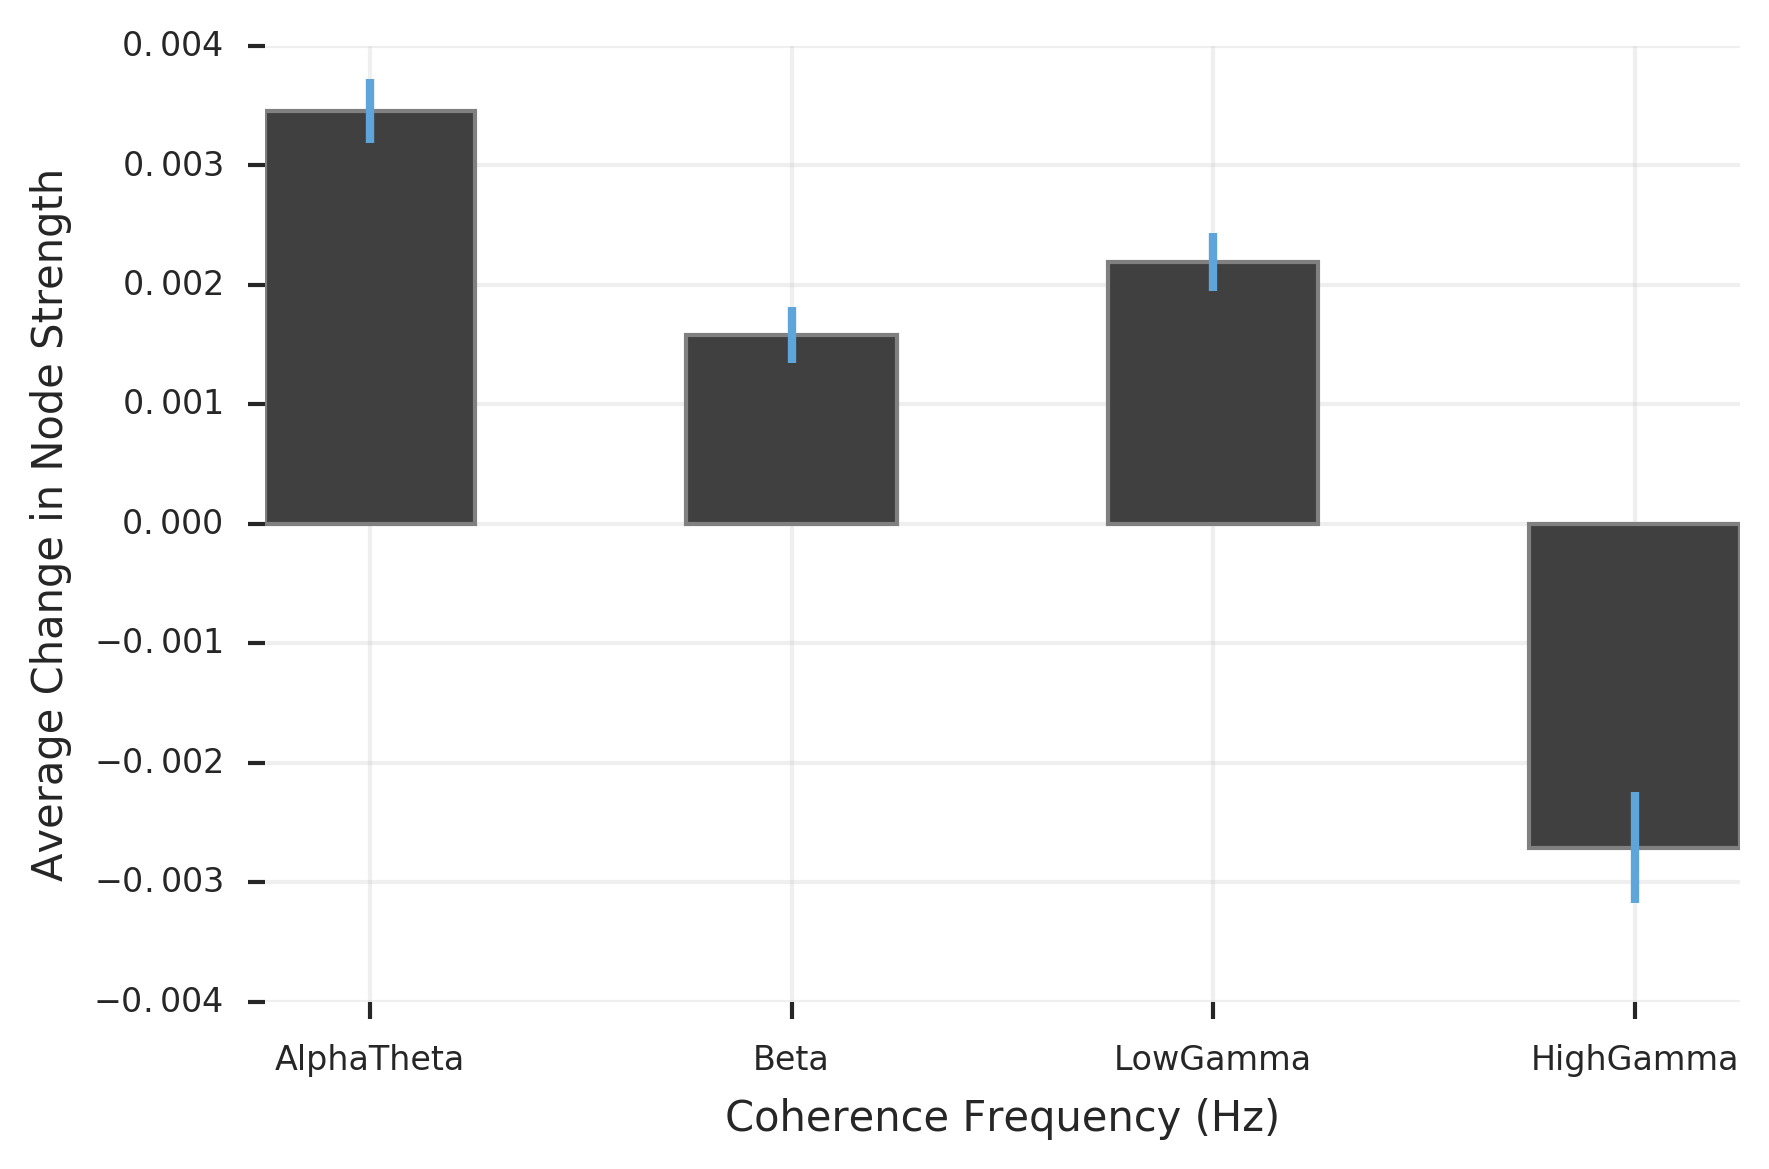

In [89]:
df = pd.read_csv('./e02-Stats/average_node_strength.csv')

%matplotlib inline

plt.figure()
ax = plt.subplot(111)

adj_freqs = ['Delta_Adj_AlphaTheta_AvgNodeStr',
             'Delta_Adj_Beta_AvgNodeStr',
             'Delta_Adj_LowGamma_AvgNodeStr',
             'Delta_Adj_HighGamma_AvgNodeStr']

delta_mean = []
delta_std = []
delta_dist = []

for afreq_ii, afreq in enumerate(adj_freqs):
    good_ix = np.flatnonzero(~np.isnan(df[afreq]))
    delta = np.array(df[afreq])[good_ix]
    
    delta_mean.append(np.mean(delta))
    delta_std.append(np.std(delta)/ np.sqrt(len(delta)))
    delta_dist.append(delta)
            
# F-Test 
fv, pv = stats.f_oneway(delta_dist[0], delta_dist[1], delta_dist[2], delta_dist[3])
print('F=%0.4f, pv=%0.4f' % (fv, pv))
print('{}'.format(stats.ttest_rel(delta_dist[0], delta_dist[1])))
print('{}'.format(stats.ttest_rel(delta_dist[0], delta_dist[2])))
print('{}'.format(stats.ttest_rel(delta_dist[0], delta_dist[3])))
print('{}'.format(stats.ttest_rel(delta_dist[1], delta_dist[2])))
print('{}'.format(stats.ttest_rel(delta_dist[1], delta_dist[3])))
print('{}'.format(stats.ttest_rel(delta_dist[2], delta_dist[3])))
      

bar1 = ax.bar(np.arange(len(delta_mean)), delta_mean, color=[0.25, 0.25, 0.25],
              width=0.5, yerr=delta_std)

ax.set_xticks(np.arange(4)+0.25)
ax.set_xticklabels([f.split('_')[2] for f in adj_freqs])
ax.set_xlabel('Coherence Frequency (Hz)')

ax.set_ylabel('Average Change in Node Strength')

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('./e02-Figures/Coh_Freq-Stim_Delta_Node_Strength.png')
plt.show()

Delta_Adj_AlphaTheta_AvgNodeStr:  -- Spearman: (rho=0.9000, pv=0.0374)
Delta_Adj_Beta_AvgNodeStr:  -- Spearman: (rho=0.9000, pv=0.0374)
Delta_Adj_LowGamma_AvgNodeStr:  -- Spearman: (rho=-0.1000, pv=0.8729)
Delta_Adj_HighGamma_AvgNodeStr:  -- Spearman: (rho=-0.9000, pv=0.0374)


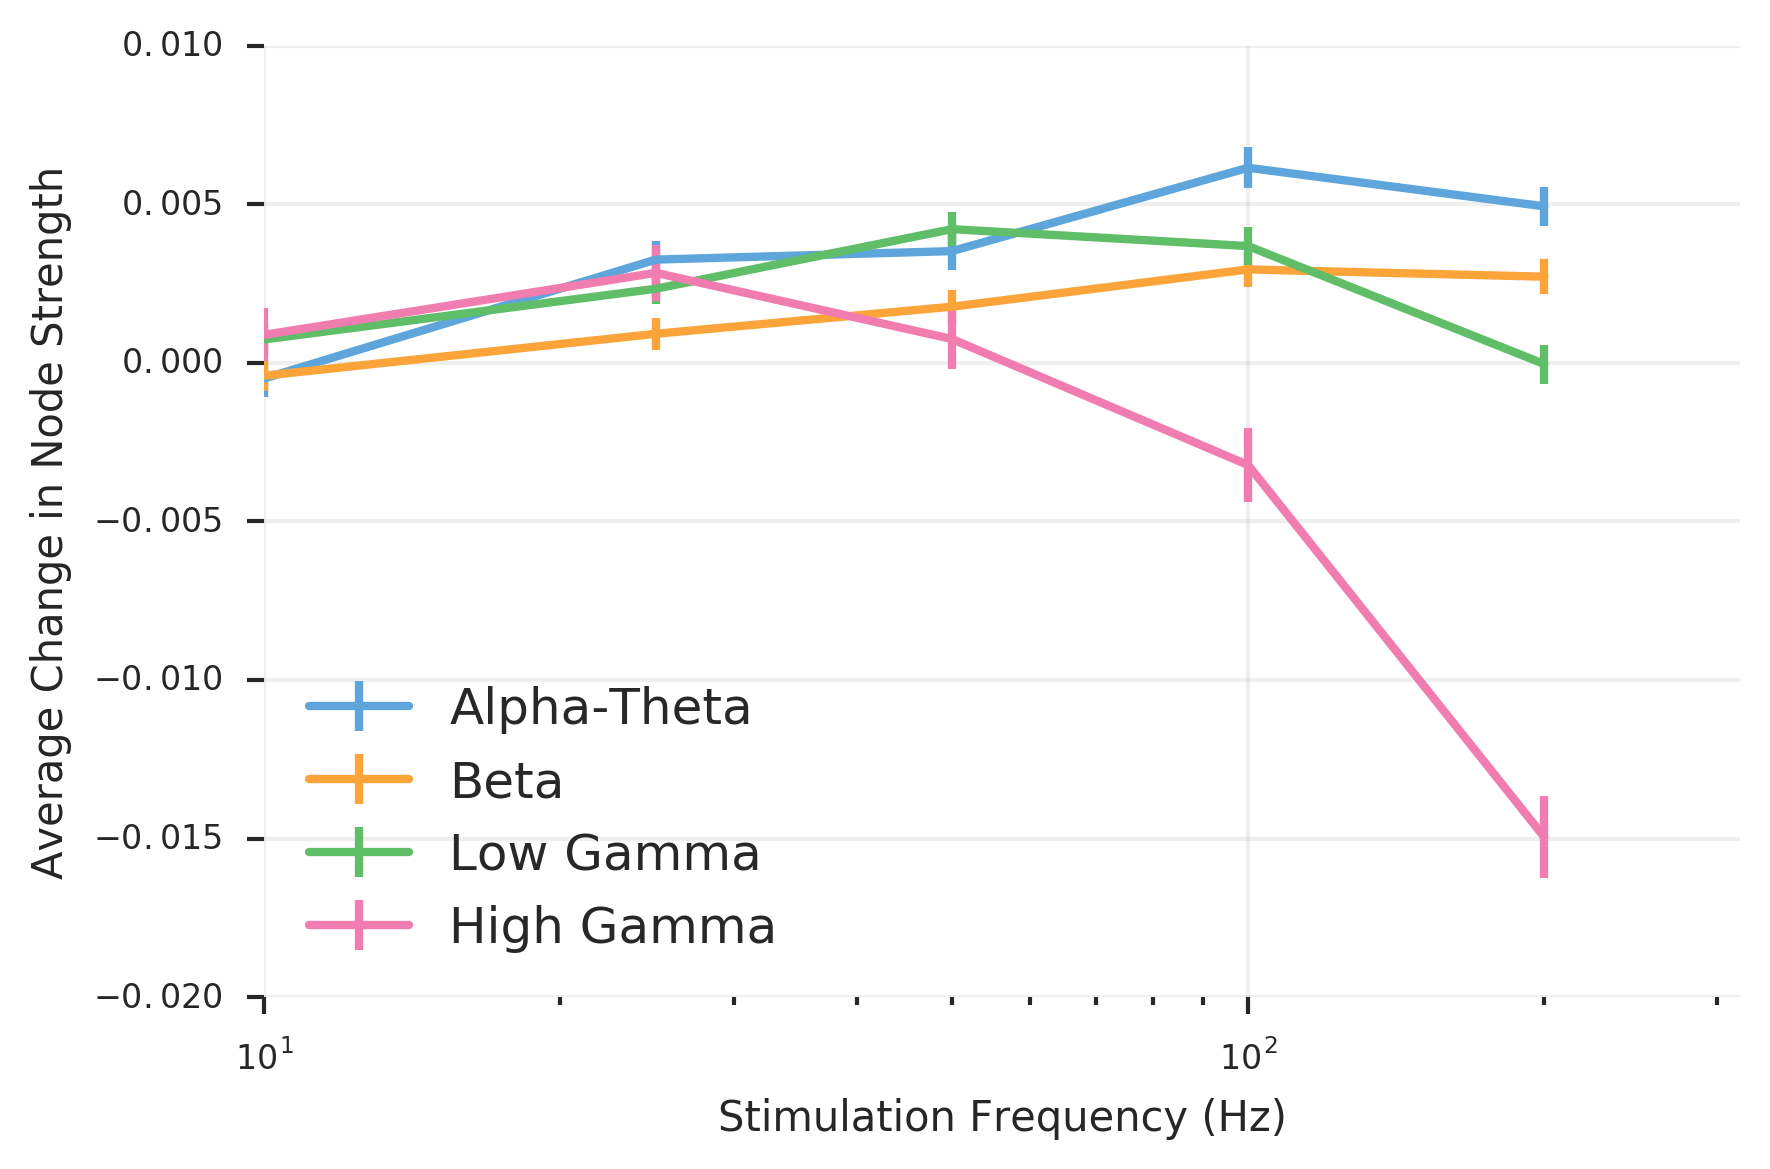

In [119]:
df = pd.read_csv('./e02-Stats/average_node_strength.csv')

%matplotlib inline

plt.figure()
ax = plt.subplot(111)

stim_freqs = np.unique(df['Stim_Freq'])
adj_freqs = ['Delta_Adj_AlphaTheta_AvgNodeStr',
             'Delta_Adj_Beta_AvgNodeStr',
             'Delta_Adj_LowGamma_AvgNodeStr',
             'Delta_Adj_HighGamma_AvgNodeStr']

for afreq in adj_freqs:
    mean_delta = []
    std_delta = []
    
    for sfreq in stim_freqs:
        mean_delta.append(np.nanmean(df[df['Stim_Freq'] == sfreq][afreq]))
        std_delta.append(np.nanstd(df[df['Stim_Freq'] == sfreq][afreq]) / \
                         np.sqrt(np.sum(~np.isnan(df[df['Stim_Freq'] == sfreq][afreq]))))
        
        
    # Spearman Correlation
    rho, pv = stats.spearmanr(stim_freqs, mean_delta)
    print('%s:  -- Spearman: (rho=%0.4f, pv=%0.4f)' % (afreq, rho, pv))
        
    ax.errorbar(stim_freqs, mean_delta, yerr=std_delta)

ax.legend(['Alpha-Theta', 'Beta', 'Low Gamma', 'High Gamma'], loc=3)
ax.set_xlabel('Stimulation Frequency (Hz)')
ax.set_xlim([10**1, 10**2.5])
ax.set_xscale('log')

ax.set_ylabel('Average Change in Node Strength')
ax.set_ylim([-0.02, 0.01])

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('./e02-Figures/Stim_Freq-Delta_Node_Strength.png')
plt.show()

#### Effect of Stimulation Amplitude on Topological Reorganization
Stimulation reorganizes frequency-dependent network topology. We track network reorganization by computing the Pearson correlation between pre-stim/post-stim configuration vector. Correlation values closer to +1 imply greater configuration similarity, and less reorganiztion, and values closer to -1 imply lower configuration similarity, and greater reorganization.

Delta_Adj_AlphaTheta_AvgNodeStr: rho=0.1758, pv=0.5656
Delta_Adj_Beta_AvgNodeStr: rho=0.0495, pv=0.8725
Delta_Adj_LowGamma_AvgNodeStr: rho=-0.0769, pv=0.8028
Delta_Adj_HighGamma_AvgNodeStr: rho=0.2637, pv=0.3839


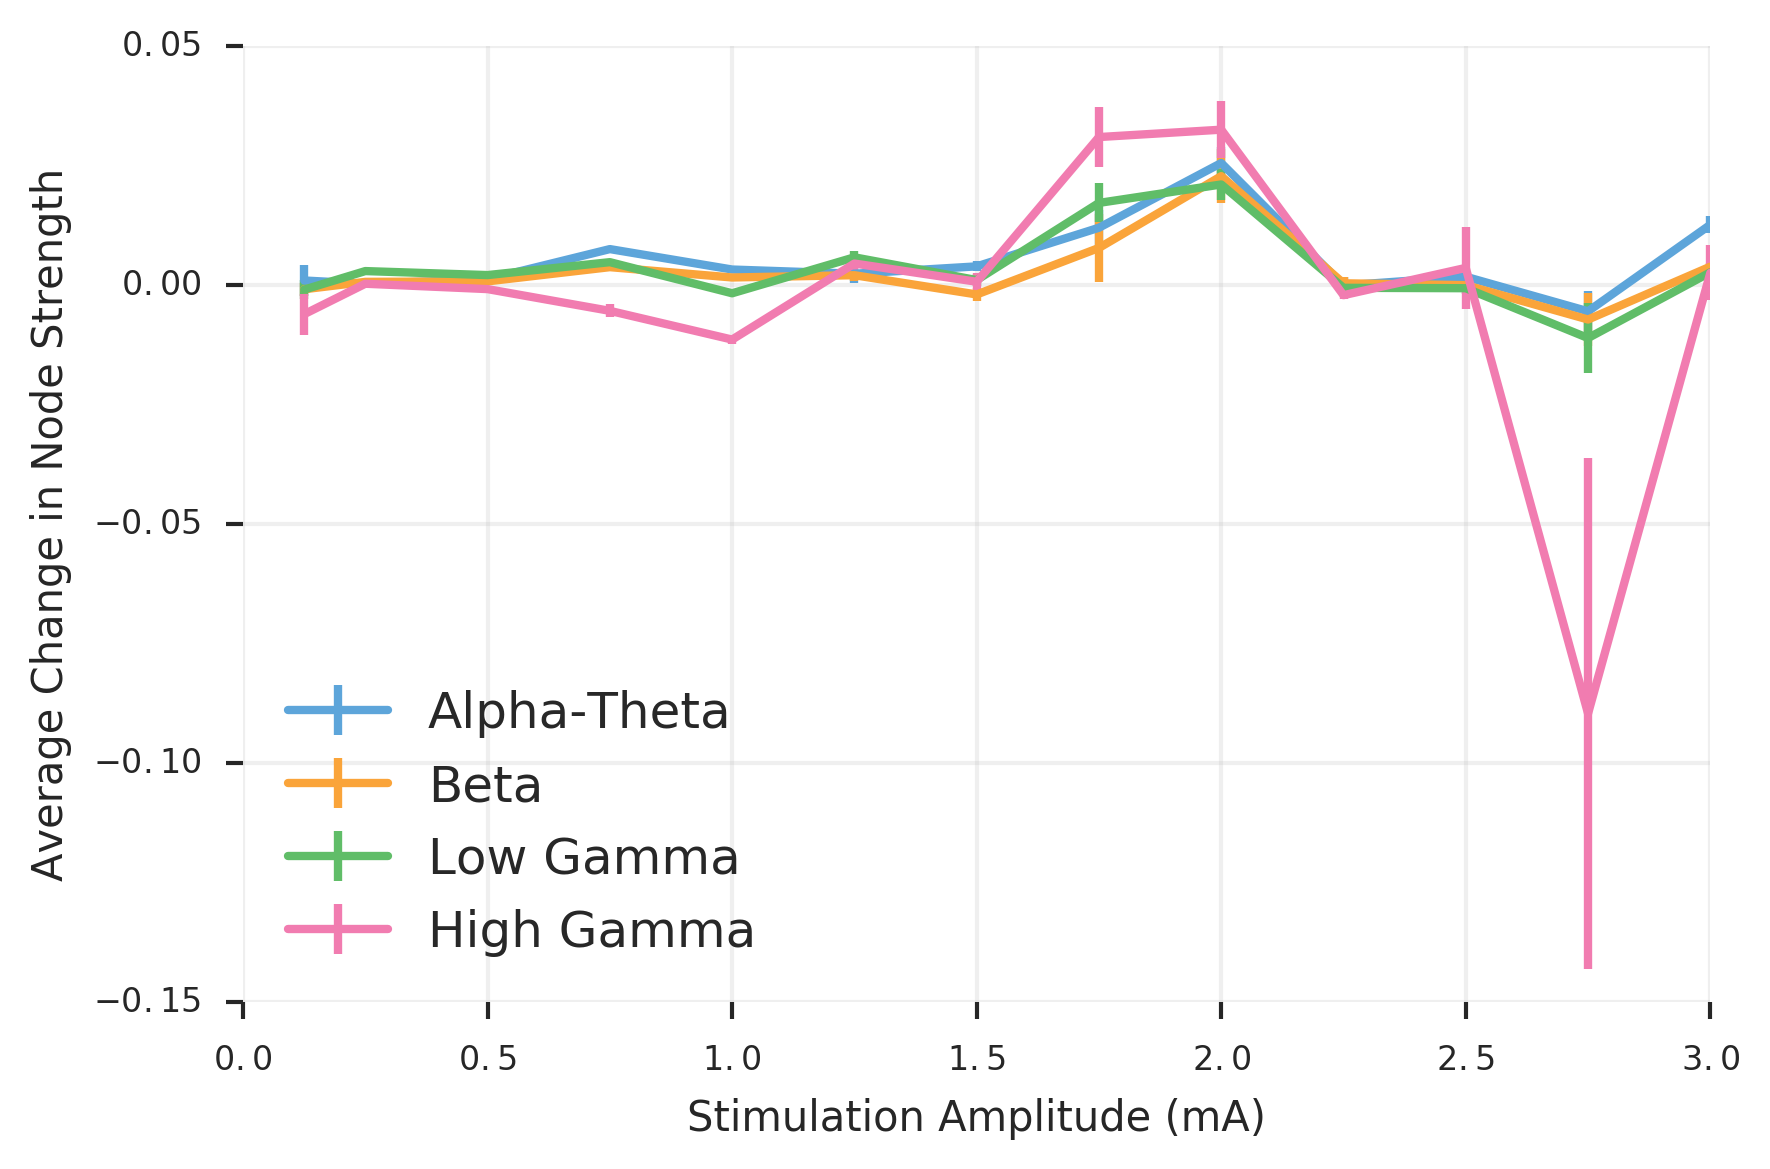

In [118]:
df = pd.read_csv('./e02-Stats/average_node_strength.csv')

%matplotlib inline

plt.figure()
ax = plt.subplot(111)

stim_amps = np.unique(df['Stim_Amp'])
adj_freqs = ['Delta_Adj_AlphaTheta_AvgNodeStr',
             'Delta_Adj_Beta_AvgNodeStr',
             'Delta_Adj_LowGamma_AvgNodeStr',
             'Delta_Adj_HighGamma_AvgNodeStr']

for afreq in adj_freqs:
    mean_delta = []
    std_delta = []
    
    for samp in stim_amps:
        mean_delta.append(np.nanmean(df[df['Stim_Amp'] == samp][afreq]))
        std_delta.append(np.nanstd(df[df['Stim_Amp'] == samp][afreq]) / \
                         np.sqrt(np.sum(~np.isnan(df[df['Stim_Amp'] == samp][afreq]))))
        
        
    # Regression
    rho, pv = stats.spearmanr(stim_amps, mean_delta)
    print('%s: rho=%0.4f, pv=%0.4f' % (afreq, rho, pv))
        
    ax.errorbar(stim_amps, mean_delta, yerr=std_delta)

ax.legend(['Alpha-Theta', 'Beta', 'Low Gamma', 'High Gamma'], loc=3)
ax.set_xlabel('Stimulation Amplitude (mA)')
ax.set_ylabel('Average Change in Node Strength')
ax.set_xlim([0.0, 3.0])
#ax.set_xscale('log')

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('./e02-Figures/Stim_Amp-Delta_Node_Strength.png')
plt.show()

#### Spatial effects of stimulation frequency on topological reorganization
Stimulation frequency impacts network topology over different spatial ranges. We use Pearson correlation to relate post-stimulation change in node strength and the distance from the stimulation site. Correlation values closer to +1 imply node strength increases over long distances and decreases over short distances; values closer to -1 imply node strength increases over short distances and increases over long distances.

AlphaTheta: t=-1.4513, pv=0.1467
Beta: t=-4.1492, pv=0.0000
LowGamma: t=-2.5031, pv=0.0123
HighGamma: t=1.4519, pv=0.1465


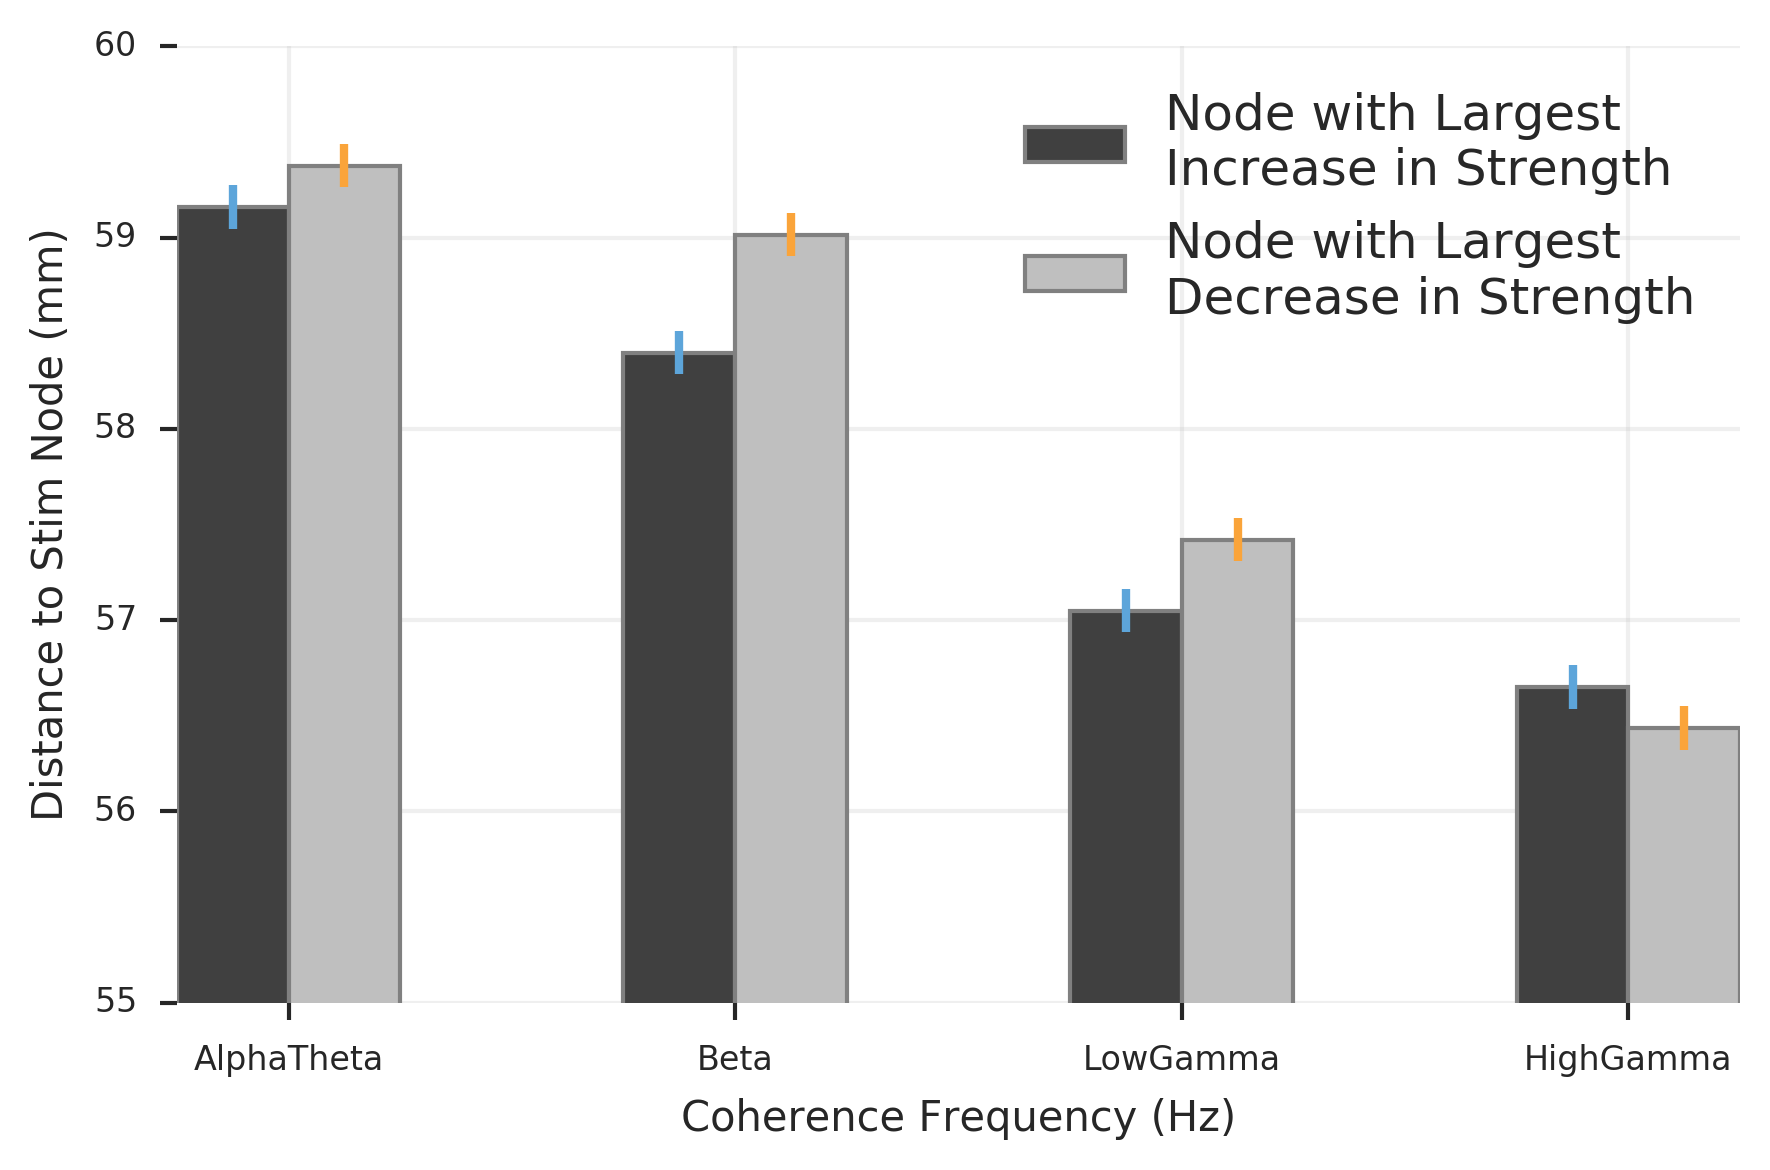

In [120]:
df = pd.read_csv('./e02-Stats/average_node_strength.csv')

%matplotlib inline

plt.figure()
ax = plt.subplot(111)

adj_freqs = [('Dist_S1_Delta_Pos_NodeStr_AlphaTheta', 'Dist_S1_Delta_Neg_NodeStr_AlphaTheta'),
             ('Dist_S1_Delta_Pos_NodeStr_Beta', 'Dist_S1_Delta_Neg_NodeStr_Beta'),
             ('Dist_S1_Delta_Pos_NodeStr_LowGamma', 'Dist_S1_Delta_Neg_NodeStr_LowGamma'),
             ('Dist_S1_Delta_Pos_NodeStr_HighGamma', 'Dist_S1_Delta_Neg_NodeStr_HighGamma')]

pos_mean = []
pos_std = []
neg_mean = []
neg_std = []

for afreq_ii, afreq in enumerate(adj_freqs):
    good_ix = np.flatnonzero(~np.isnan(df[afreq[0]]))
    pos = np.array(df[afreq[0]])[good_ix]
    neg = np.array(df[afreq[1]])[good_ix]
    
    pos_mean.append(np.mean(pos))
    pos_std.append(np.std(pos)/ np.sqrt(len(pos)))
    
    neg_mean.append(np.mean(neg))
    neg_std.append(np.std(neg)/ np.sqrt(len(neg)))
        
    # T-Test 
    tv, pv = stats.ttest_rel(pos, neg)
    print('%s: t=%0.4f, pv=%0.4f' % (afreq[0].split('_')[-1], tv, pv))

bar1 = ax.bar(np.arange(len(pos_mean)), pos_mean, color=[0.25, 0.25, 0.25],
              width=0.25, yerr=pos_std)

bar2 = ax.bar(np.arange(len(neg_mean)) + 0.25, neg_mean, color=[0.75, 0.75, 0.75],
              width=0.25, yerr=neg_std)

ax.legend([bar1[0], bar2[0]], ['Node with Largest\nIncrease in Strength', 'Node with Largest\nDecrease in Strength'])
ax.set_xticks(0.25 + np.arange(4))
ax.set_xticklabels([f[0].split('_')[-1] for f in adj_freqs])
ax.set_xlabel('Coherence Frequency (Hz)')

ax.set_ylim([55, 60])
ax.set_ylabel('Distance to Stim Node (mm)')

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('./e02-Figures/Coh_Freq-Stim_Distance_Node_Strength.png')
plt.show()

Dist_S1_Delta_Pos_NodeStr_AlphaTheta:  -- Spearman: (rho=-0.8000, pv=0.2000)
Dist_S1_Delta_Pos_NodeStr_Beta:  -- Spearman: (rho=-1.0000, pv=0.0000)
Dist_S1_Delta_Pos_NodeStr_LowGamma:  -- Spearman: (rho=-1.0000, pv=0.0000)
Dist_S1_Delta_Pos_NodeStr_HighGamma:  -- Spearman: (rho=-1.0000, pv=0.0000)


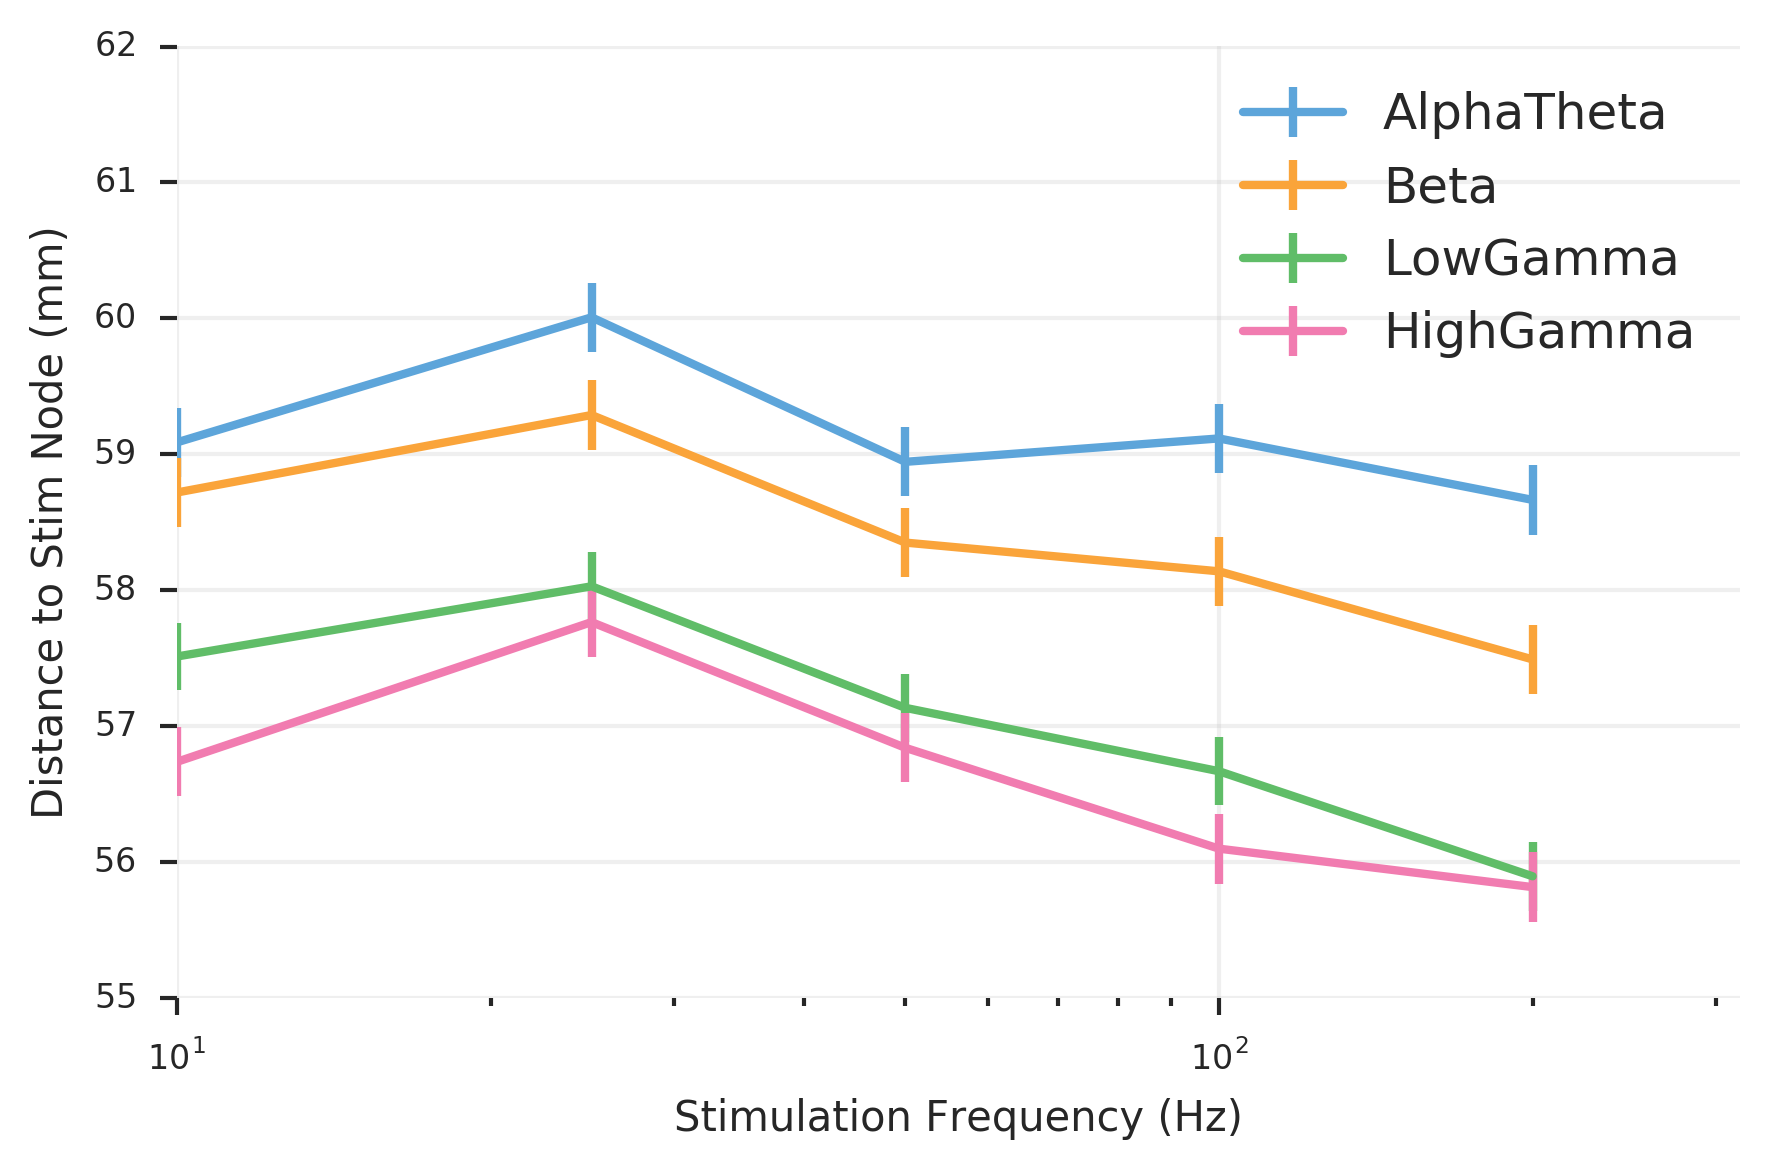

In [122]:
df = pd.read_csv('./e02-Stats/average_node_strength.csv')

%matplotlib inline

plt.figure()
ax = plt.subplot(111)

stim_freqs = np.unique(df['Stim_Freq'])
adj_freqs = ['Dist_S1_Delta_Pos_NodeStr_AlphaTheta',
             'Dist_S1_Delta_Pos_NodeStr_Beta',
             'Dist_S1_Delta_Pos_NodeStr_LowGamma',
             'Dist_S1_Delta_Pos_NodeStr_HighGamma']

for afreq in adj_freqs:
    mean_delta = []
    std_delta = []
    
    for sfreq in stim_freqs:
        mean_delta.append(np.nanmean(df[df['Stim_Freq'] == sfreq][afreq]))
        std_delta.append(np.nanstd(df[df['Stim_Freq'] == sfreq][afreq]) / \
                         np.sqrt(np.sum(~np.isnan(df[df['Stim_Freq'] == sfreq][afreq]))))
            
    # Spearman Correlation
    rho, pv = stats.spearmanr(stim_freqs[1:], mean_delta[1:])
    print('%s:  -- Spearman: (rho=%0.4f, pv=%0.4f)' % (afreq, rho, pv))
            
    ax.errorbar(stim_freqs, mean_delta, yerr=std_delta)

ax.legend(['{}'.format(f.split('_')[-1]) for f in adj_freqs])
ax.set_xlabel('Stimulation Frequency (Hz)')
ax.set_xlim([10**1, 10**2.5])
ax.set_xscale('log')

ax.set_ylabel('Distance to Stim Node (mm)')
ax.set_ylim([55, 62])

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('./e02-Figures/Stim_Freq-Stim_Distance_Node_Strength.png')
plt.show()

#### Spatial effects of stimulation amplitude on topological reorganization
Stimulation amplitude impacts network topology over different spatial ranges. We use Pearson correlation to relate post-stimulation change in node strength and the distance from the stimulation site. Correlation values closer to +1 imply node strength increases over long distances and decreases over short distances; values closer to -1 imply node strength increases over short distances and increases over long distances.

Dist_S1_Delta_Pos_NodeStr_AlphaTheta: rho=0.4066, pv=0.1680
Dist_S1_Delta_Pos_NodeStr_Beta: rho=0.4176, pv=0.1557
Dist_S1_Delta_Pos_NodeStr_LowGamma: rho=0.4066, pv=0.1680
Dist_S1_Delta_Pos_NodeStr_HighGamma: rho=0.5275, pv=0.0640


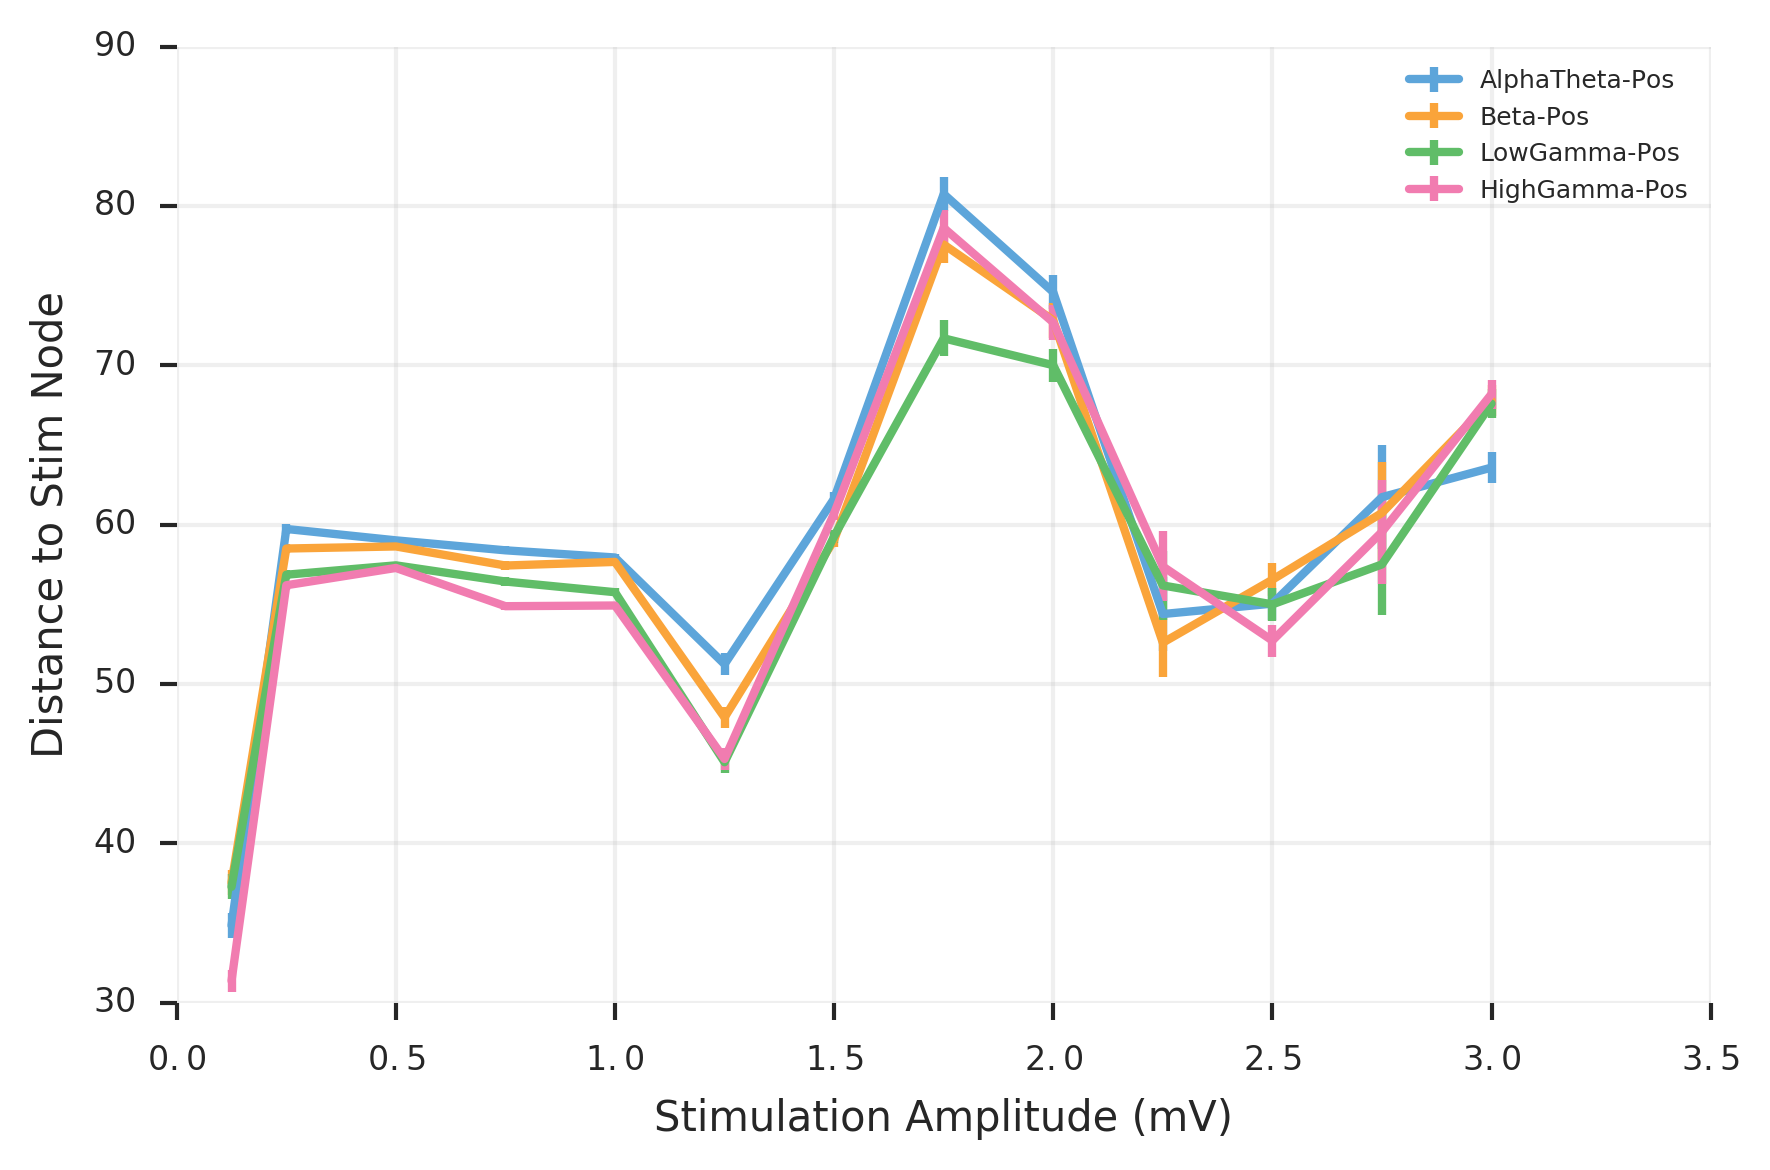

In [458]:
df = pd.read_csv('./e02-Stats/average_node_strength.csv')

%matplotlib inline

plt.figure()
ax = plt.subplot(111)

stim_amps = np.unique(df['Stim_Amp'])
adj_freqs = ['Dist_S1_Delta_Pos_NodeStr_AlphaTheta',
             'Dist_S1_Delta_Pos_NodeStr_Beta',
             'Dist_S1_Delta_Pos_NodeStr_LowGamma',
             'Dist_S1_Delta_Pos_NodeStr_HighGamma']

for afreq in adj_freqs:
    mean_delta = []
    std_delta = []
    
    for samp in stim_amps:
        mean_delta.append(np.nanmean(df[df['Stim_Amp'] == samp][afreq]))
        std_delta.append(np.nanstd(df[df['Stim_Amp'] == samp][afreq]) / \
                         np.sqrt(np.sum(~np.isnan(df[df['Stim_Amp'] == samp][afreq]))))
        
    # Regression
    rho, pv = stats.spearmanr(stim_amps, mean_delta)
    print('%s: rho=%0.4f, pv=%0.4f' % (afreq, rho, pv))
        
    ax.errorbar(stim_amps, mean_delta, yerr=std_delta)

ax.legend(['{}-{}'.format(f.split('_')[-1], f.split('_')[3]) for f in adj_freqs])
ax.set_xlabel('Stimulation Amplitude (mV)')
ax.set_ylabel('Distance to Stim Node')
ax.set_xlim([0.0, 3.5])
#ax.set_xscale('log')

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('./e02-Figures/Stim_Amp-Stim_Distance_Node_Strength.svg')
plt.show()

# Stimulation node topology 

## Stim Centrality

In [510]:
data_table_1 = {'Subject_ID': [],                
                'Stim_AlphaTheta_ZNodeStr': [],
                'Stim_Beta_ZNodeStr': [],
                'Stim_LowGamma_ZNodeStr': [],
                'Stim_HighGamma_ZNodeStr': [],
                
                'Stim_AlphaTheta_ZContrCentr': [],
                'Stim_Beta_ZContrCentr': [],
                'Stim_LowGamma_ZContrCentr': [],
                'Stim_HighGamma_ZContrCentr': []}

for subj_ii, subj_id in enumerate(subj_dict_baseline.keys()):
    print('Subject: {} ({} of {})'.format(subj_id, subj_ii+1, len(subj_dict_baseline.keys())))
    
    try:
        S1_ix = meta_dict[subj_id]['stim_nodes'][0]
    except:
        continue
    
    ns_base_dist_alphatheta = []
    ns_base_dist_beta = []
    ns_base_dist_lowgamma = []
    ns_base_dist_highgamma = []
    
    cc_base_dist_alphatheta = []
    cc_base_dist_beta = []
    cc_base_dist_lowgamma = []
    cc_base_dist_highgamma = []
        
    for trial_id in subj_dict_baseline[subj_id].keys():
        # Load Adjacency
        adj_path = subj_dict_baseline[subj_id][trial_id]['adj_path']
        df = np.load(adj_path)
        adj = df['adj'].item()                

        adj_base_alphatheta = adj['No_Stim']['AlphaTheta']
        adj_base_beta = adj['No_Stim']['Beta']
        adj_base_lowgamma = adj['No_Stim']['LowGamma']
        adj_base_highgamma = adj['No_Stim']['HighGamma']
        
        ns_base_dist_alphatheta.append(np.mean(adj_base_alphatheta, axis=0))
        ns_base_dist_beta.append(np.mean(adj_base_beta, axis=0))
        ns_base_dist_lowgamma.append(np.mean(adj_base_lowgamma, axis=0))
        ns_base_dist_highgamma.append(np.mean(adj_base_highgamma, axis=0))

        cc_base_dist_alphatheta.append(Echobase.Network.Metrics.nodetopo.node_control(adj_base_alphatheta))
        cc_base_dist_beta.append(Echobase.Network.Metrics.nodetopo.node_control(adj_base_beta))
        cc_base_dist_lowgamma.append(Echobase.Network.Metrics.nodetopo.node_control(adj_base_lowgamma))
        cc_base_dist_highgamma.append(Echobase.Network.Metrics.nodetopo.node_control(adj_base_highgamma))
        
    ns_base_avg_alphatheta = np.mean(np.array(ns_base_dist_alphatheta), axis=0)
    ns_base_avg_beta = np.mean(np.array(ns_base_dist_beta), axis=0)
    ns_base_avg_lowgamma = np.mean(np.array(ns_base_dist_lowgamma), axis=0)
    ns_base_avg_highgamma = np.mean(np.array(ns_base_dist_highgamma), axis=0)

    cc_base_avg_alphatheta = np.mean(np.array(cc_base_dist_alphatheta), axis=0)
    cc_base_avg_beta = np.mean(np.array(cc_base_dist_beta), axis=0)
    cc_base_avg_lowgamma = np.mean(np.array(cc_base_dist_lowgamma), axis=0)
    cc_base_avg_highgamma = np.mean(np.array(cc_base_dist_highgamma), axis=0)
    
    #S1_ix = np.random.permutation(len(ns_base_avg_alphatheta))[0]
    
    try:
        zns_base_avg_alphatheta = (ns_base_avg_alphatheta[S1_ix] - np.nanmean(ns_base_avg_alphatheta)) / np.nanstd(ns_base_avg_alphatheta)   
        zns_base_avg_beta = (ns_base_avg_beta[S1_ix] - np.nanmean(ns_base_avg_beta)) / np.nanstd(ns_base_avg_beta)   
        zns_base_avg_lowgamma = (ns_base_avg_lowgamma[S1_ix] - np.nanmean(ns_base_avg_lowgamma)) / np.nanstd(ns_base_avg_lowgamma)   
        zns_base_avg_highgamma = (ns_base_avg_highgamma[S1_ix] - np.nanmean(ns_base_avg_highgamma)) / np.nanstd(ns_base_avg_highgamma)       
        
        zcc_base_avg_alphatheta = (cc_base_avg_alphatheta[S1_ix] - np.nanmean(cc_base_avg_alphatheta)) / np.nanstd(cc_base_avg_alphatheta)
        zcc_base_avg_beta = (cc_base_avg_beta[S1_ix] - np.nanmean(cc_base_avg_beta)) / np.nanstd(cc_base_avg_beta)   
        zcc_base_avg_lowgamma = (cc_base_avg_lowgamma[S1_ix] - np.nanmean(cc_base_avg_lowgamma)) / np.nanstd(cc_base_avg_lowgamma)   
        zcc_base_avg_highgamma = (cc_base_avg_highgamma[S1_ix] - np.nanmean(cc_base_avg_highgamma)) / np.nanstd(cc_base_avg_highgamma)               
    except:
        continue

    # Add to Data Table 1
    df.close()
    data_table_1['Subject_ID'].append(subj_id)    
    data_table_1['Stim_AlphaTheta_ZNodeStr'].append(zns_base_avg_alphatheta)
    data_table_1['Stim_Beta_ZNodeStr'].append(zns_base_avg_beta)
    data_table_1['Stim_LowGamma_ZNodeStr'].append(zns_base_avg_lowgamma)
    data_table_1['Stim_HighGamma_ZNodeStr'].append(zns_base_avg_highgamma)
    
    data_table_1['Stim_AlphaTheta_ZContrCentr'].append(zcc_base_avg_alphatheta)
    data_table_1['Stim_Beta_ZContrCentr'].append(zcc_base_avg_beta)
    data_table_1['Stim_LowGamma_ZContrCentr'].append(zcc_base_avg_lowgamma)
    data_table_1['Stim_HighGamma_ZContrCentr'].append(zcc_base_avg_highgamma)

# Save Data Tables for R-stats
df = pd.DataFrame(data_table_1, columns=data_table_1.keys())
df.to_csv('./e02-Stats/stim_node_strength.csv')

Subject: R1084T (1 of 53)
Subject: R1093J_1 (2 of 53)
Subject: R1121M (3 of 53)
Subject: R1131M (4 of 53)
Subject: R1086M (5 of 53)
Subject: R1070T (6 of 53)
Subject: R1068J (7 of 53)
Subject: R1101T (8 of 53)
Subject: R1064E_1 (9 of 53)
Subject: R1052E_1 (10 of 53)
Subject: R1125T (11 of 53)
Subject: R1066P (12 of 53)
Subject: R1054J (13 of 53)
Subject: R1124J_1 (14 of 53)
Subject: R1062J (15 of 53)
Subject: R1134T (16 of 53)
Subject: R1114C (17 of 53)
Subject: R1100D (18 of 53)
Subject: R1045E (19 of 53)
Subject: R1025P (20 of 53)
Subject: R1050M (21 of 53)
Subject: R1096E (22 of 53)
Subject: R1060M (23 of 53)
Subject: R1122E (24 of 53)
Subject: R1120E (25 of 53)
Subject: R1064E (26 of 53)
Subject: R1074M (27 of 53)
Subject: R1105E (28 of 53)
Subject: R1108J (29 of 53)
Subject: R1059J_2 (30 of 53)
Subject: R1130M (31 of 53)
Subject: R1067P (32 of 53)
Subject: R1059J_1 (33 of 53)
Subject: R1081J (34 of 53)
Subject: R1044J (35 of 53)
Subject: R1112M (36 of 53)
Subject: R1069M (37 of 53

### Generate plots

#### Effect of Stim Node Strength (Baseline) on Average Connectivity Change

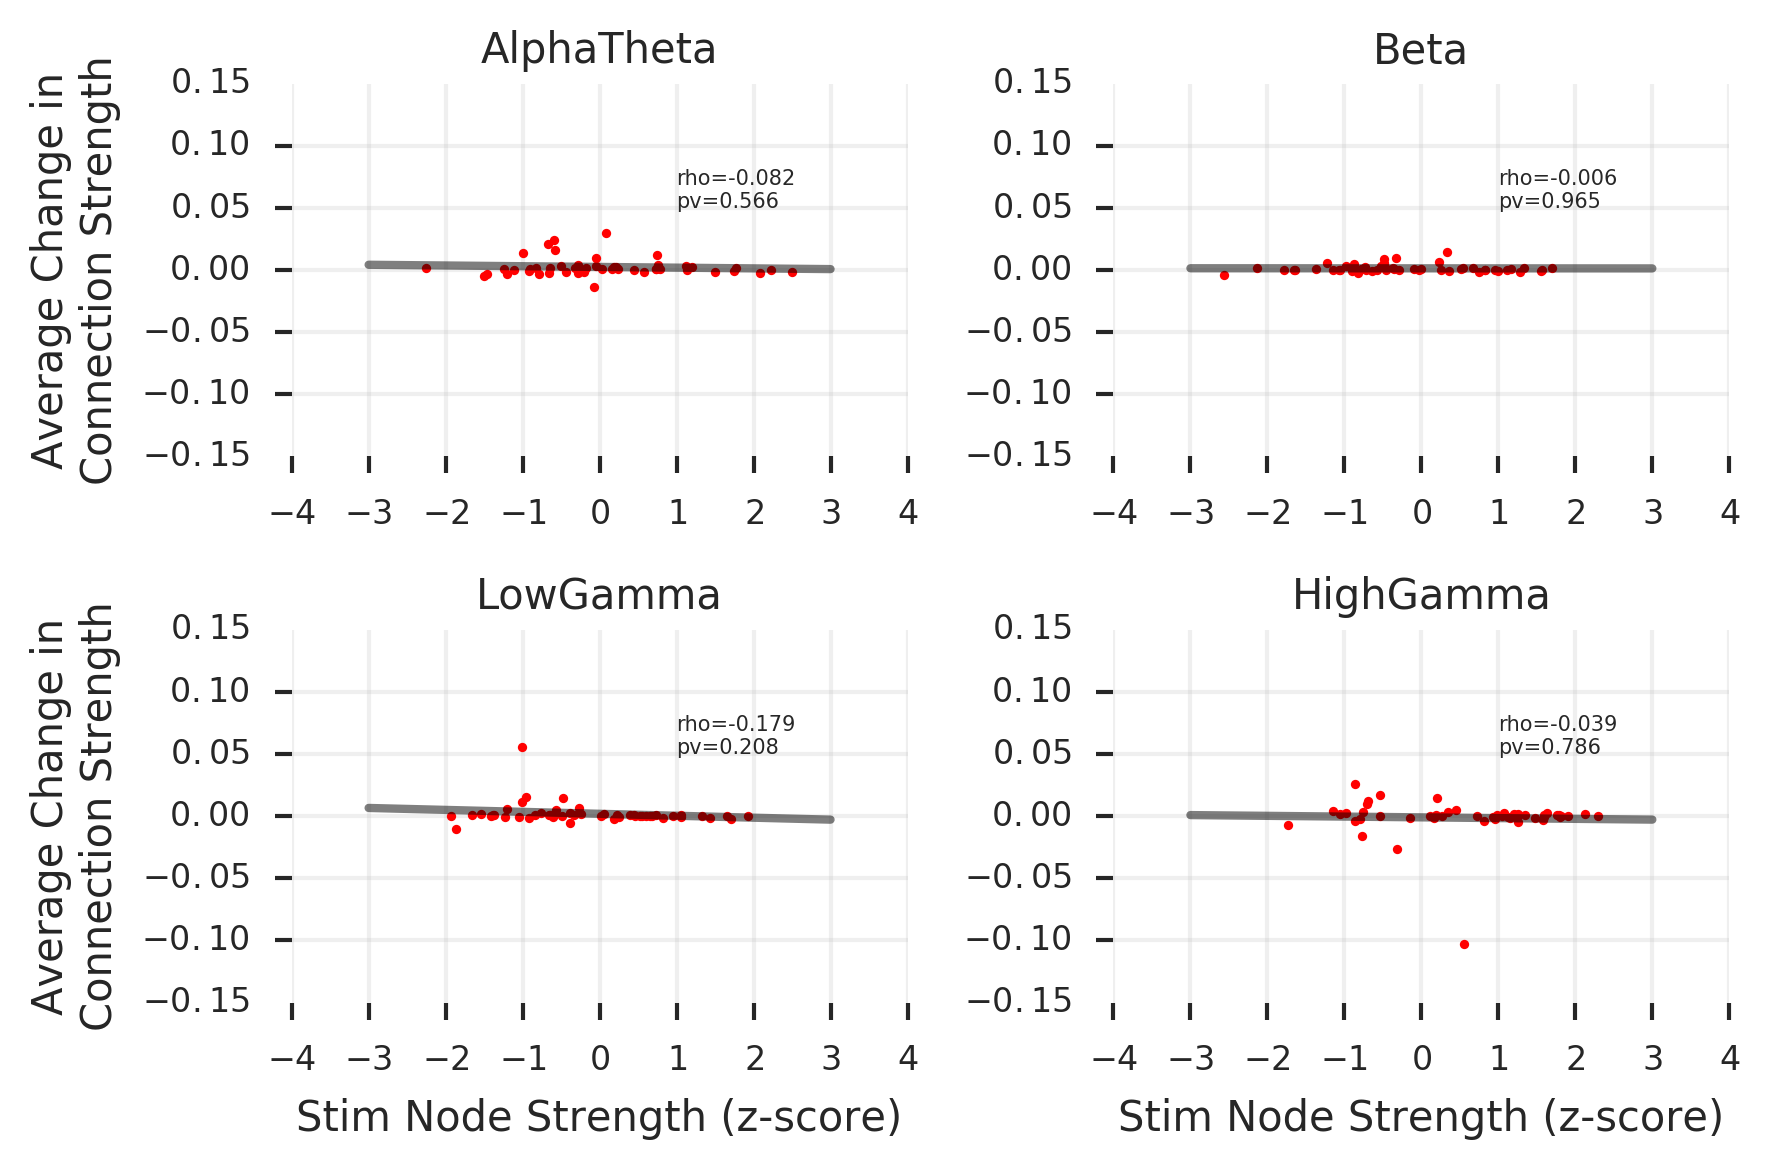

In [154]:
df_stim = pd.read_csv('./e02-Stats/average_node_strength.csv')
df_base = pd.read_csv('./e02-Stats/stim_node_strength.csv')

common_subj_id = np.intersect1d(df_stim['Subject_ID'], df_base['Subject_ID'])

%matplotlib inline

plt.figure()

adj_freqs = [('Stim_AlphaTheta_ZNodeStr', 'Delta_Adj_AlphaTheta_AvgNodeStr'),
             ('Stim_Beta_ZNodeStr', 'Delta_Adj_Beta_AvgNodeStr'),
             ('Stim_LowGamma_ZNodeStr', 'Delta_Adj_LowGamma_AvgNodeStr'),
             ('Stim_HighGamma_ZNodeStr', 'Delta_Adj_HighGamma_AvgNodeStr')]

for ii, afreq in enumerate(adj_freqs):
    ax = plt.subplot(2, 2, ii+1)
    
    base = []
    stim = []
    for subj_id in common_subj_id:
        sel_subj_base = np.nanmean(df_base[df_base['Subject_ID'] == subj_id][afreq[0]])
        
        sel_subj_stim = np.nanmean(df_stim[df_stim['Subject_ID'] == subj_id][afreq[1]])
        
        base.append(sel_subj_base)
        stim.append(sel_subj_stim)
    
    # Regression
    slope, yint, rho, pv, stderr = stats.linregress(base, stim)
    ax.plot([-3, 3], slope*np.array([-3, 3])+yint, 'k', alpha=0.5)    
    ax.scatter(base, stim, s=5,
               color='r', lw=0)
    
    ax.text(1.0, 0.05, 'rho=%0.3f\npv=%0.3f' % (rho, pv), fontsize=5.0)
    
    ax.set_xlim([-4, 4])
    ax.set_ylim([-0.15, 0.15])
    if ii in [0, 2]:
        ax.set_ylabel('Average Change in\nConnection Strength')
    if ii in [2, 3]:
        ax.set_xlabel('Stim Node Strength (z-score)')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(afreq[0].split('_')[1])

plt.savefig('./e02-Figures/Baseline_Node_Strength-Average_Delta_Node_Strength.png')
plt.show()

#### Effect of Stim Node Strength (Baseline) on Strongest Node Strength

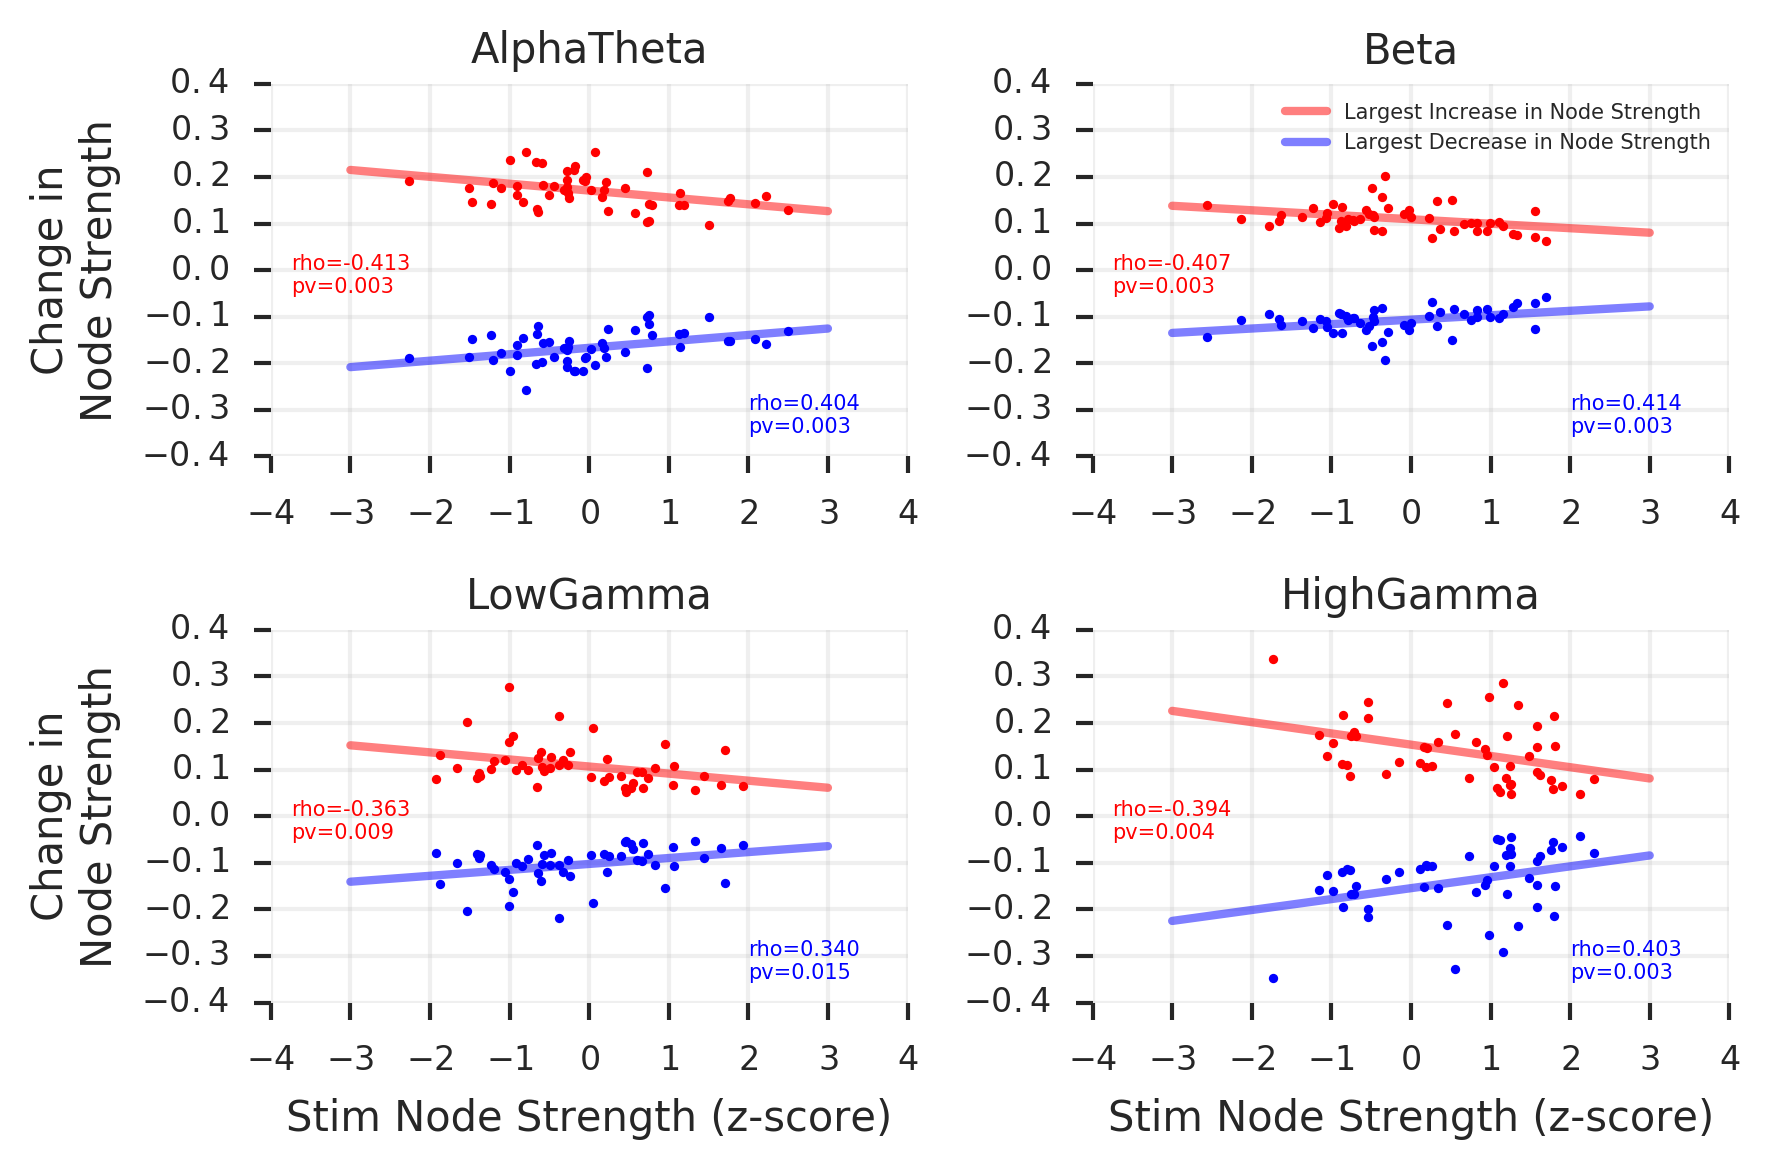

In [152]:
df_stim = pd.read_csv('./e02-Stats/average_node_strength.csv')
df_base = pd.read_csv('./e02-Stats/stim_node_strength.csv')

common_subj_id = np.intersect1d(df_stim['Subject_ID'], df_base['Subject_ID'])

%matplotlib inline

plt.figure()

adj_freqs = [('Stim_AlphaTheta_ZNodeStr', 'Delta_Pos_NodeStr_AlphaTheta', 'Delta_Neg_NodeStr_AlphaTheta'),
             ('Stim_Beta_ZNodeStr', 'Delta_Pos_NodeStr_Beta', 'Delta_Neg_NodeStr_Beta'),
             ('Stim_LowGamma_ZNodeStr', 'Delta_Pos_NodeStr_LowGamma', 'Delta_Neg_NodeStr_LowGamma'),
             ('Stim_HighGamma_ZNodeStr', 'Delta_Pos_NodeStr_HighGamma', 'Delta_Neg_NodeStr_HighGamma')]

for ii, afreq in enumerate(adj_freqs):
    ax = plt.subplot(2, 2, ii+1)
    
    base = []
    stim_pos = []
    stim_neg = []    
    for subj_id in common_subj_id:
        sel_subj_base = np.nanmean(df_base[df_base['Subject_ID'] == subj_id][afreq[0]])
        base.append(sel_subj_base)
        
        sel_subj_stim = np.nanmean(df_stim[df_stim['Subject_ID'] == subj_id][afreq[1]])
        stim_pos.append(sel_subj_stim)        

        sel_subj_stim = np.nanmean(df_stim[df_stim['Subject_ID'] == subj_id][afreq[2]])
        stim_neg.append(sel_subj_stim)        

    # Regression
    for stim, color, coord in [(stim_pos, 'r', (-3.75, -0.05)), (stim_neg, 'b', (2.0, -0.35))]:
        slope, yint, rho, pv, stderr = stats.linregress(base, stim)
        ax.plot([-3, 3], slope*np.array([-3, 3])+yint, 'k', color=color, alpha=0.5)    
        ax.scatter(base, stim, s=5,
                   color=color, lw=0)

        rho, pv = stats.spearmanr(base, stim)
        ax.text(coord[0], coord[1], 'rho=%0.3f\npv=%0.3f' % (rho, pv), fontsize=5.0, color=color)
    
    ax.set_xlim([-4, 4])
    ax.set_ylim([-0.4, 0.4])
    if ii in [0, 2]:
            ax.set_ylabel('Change in\nNode Strength')
    if ii in [2, 3]:
        ax.set_xlabel('Stim Node Strength (z-score)')
    if ii == 1:
        ax.legend(['Largest Increase in Node Strength', 'Largest Decrease in Node Strength'], fontsize=5)

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(afreq[0].split('_')[1])

plt.savefig('./e02-Figures/Baseline_Node_Strength-Delta_Node_Strength.png')
plt.show()

# Adjacency Matrix

Adjacency.R1054J.Freq_10.Amp_1.Trial_176.npz
Stim Nodes: [106, 107]
Baseline Adjacency


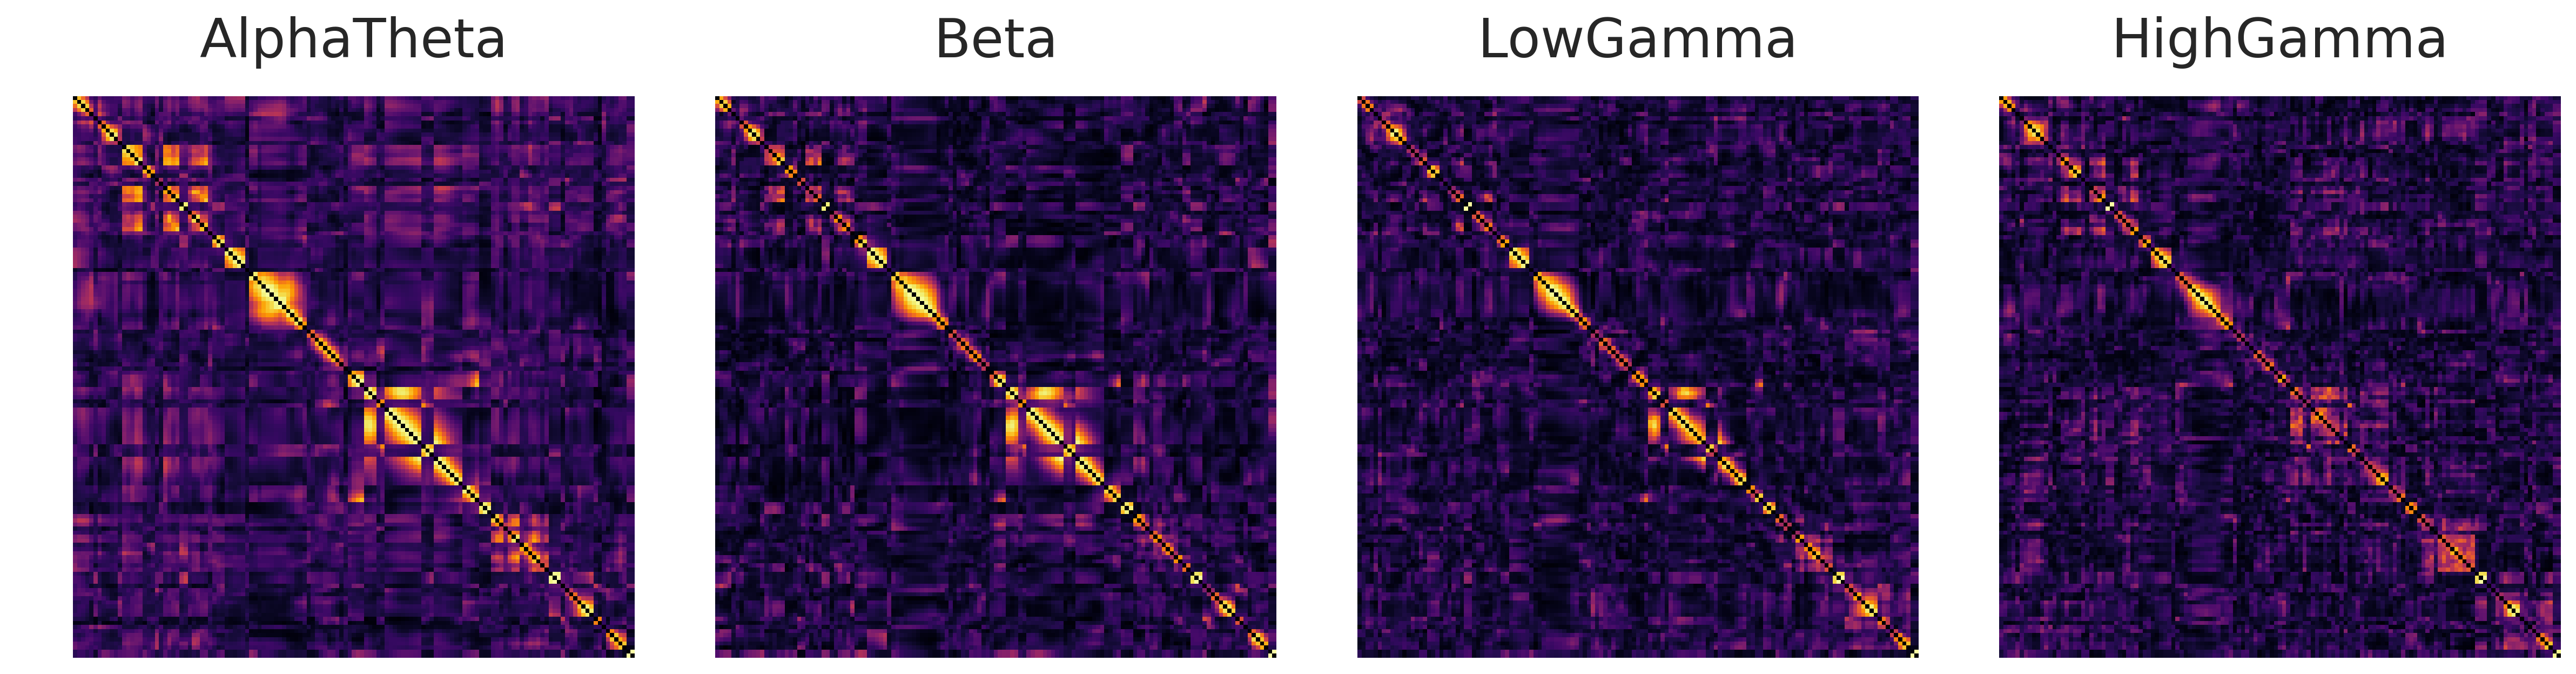

Pre-Stimulus Adjacency


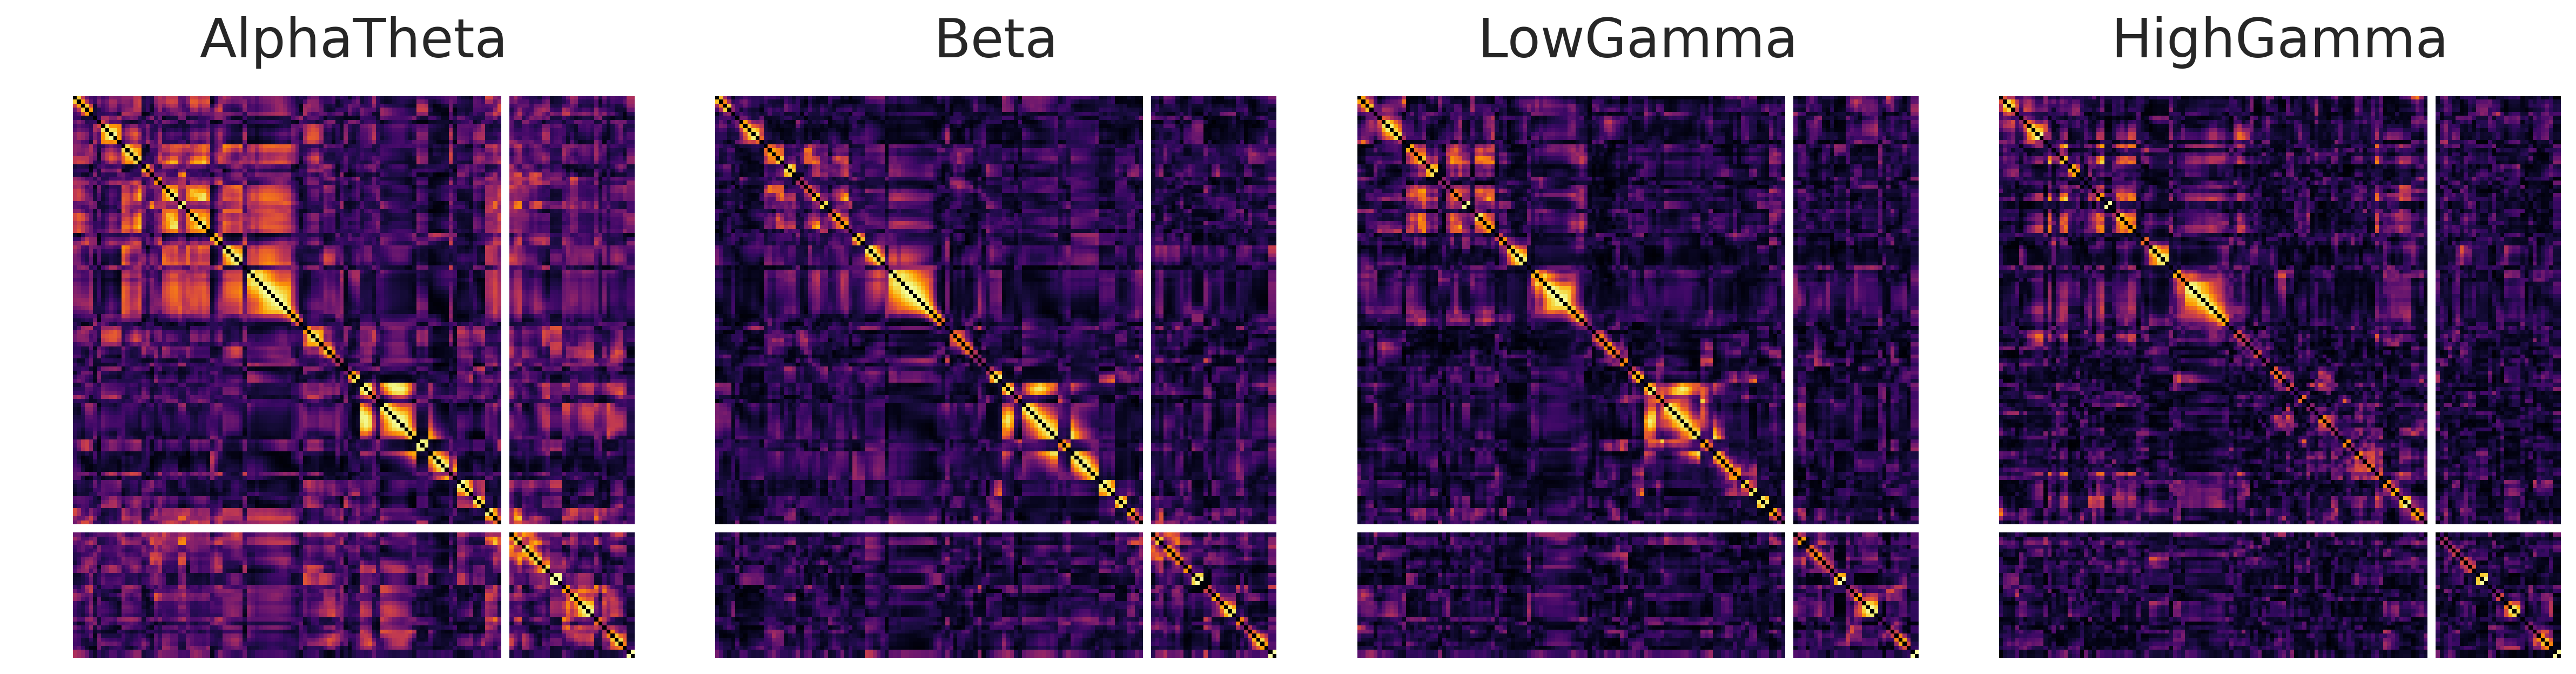

Post-Stimulus Adjacency


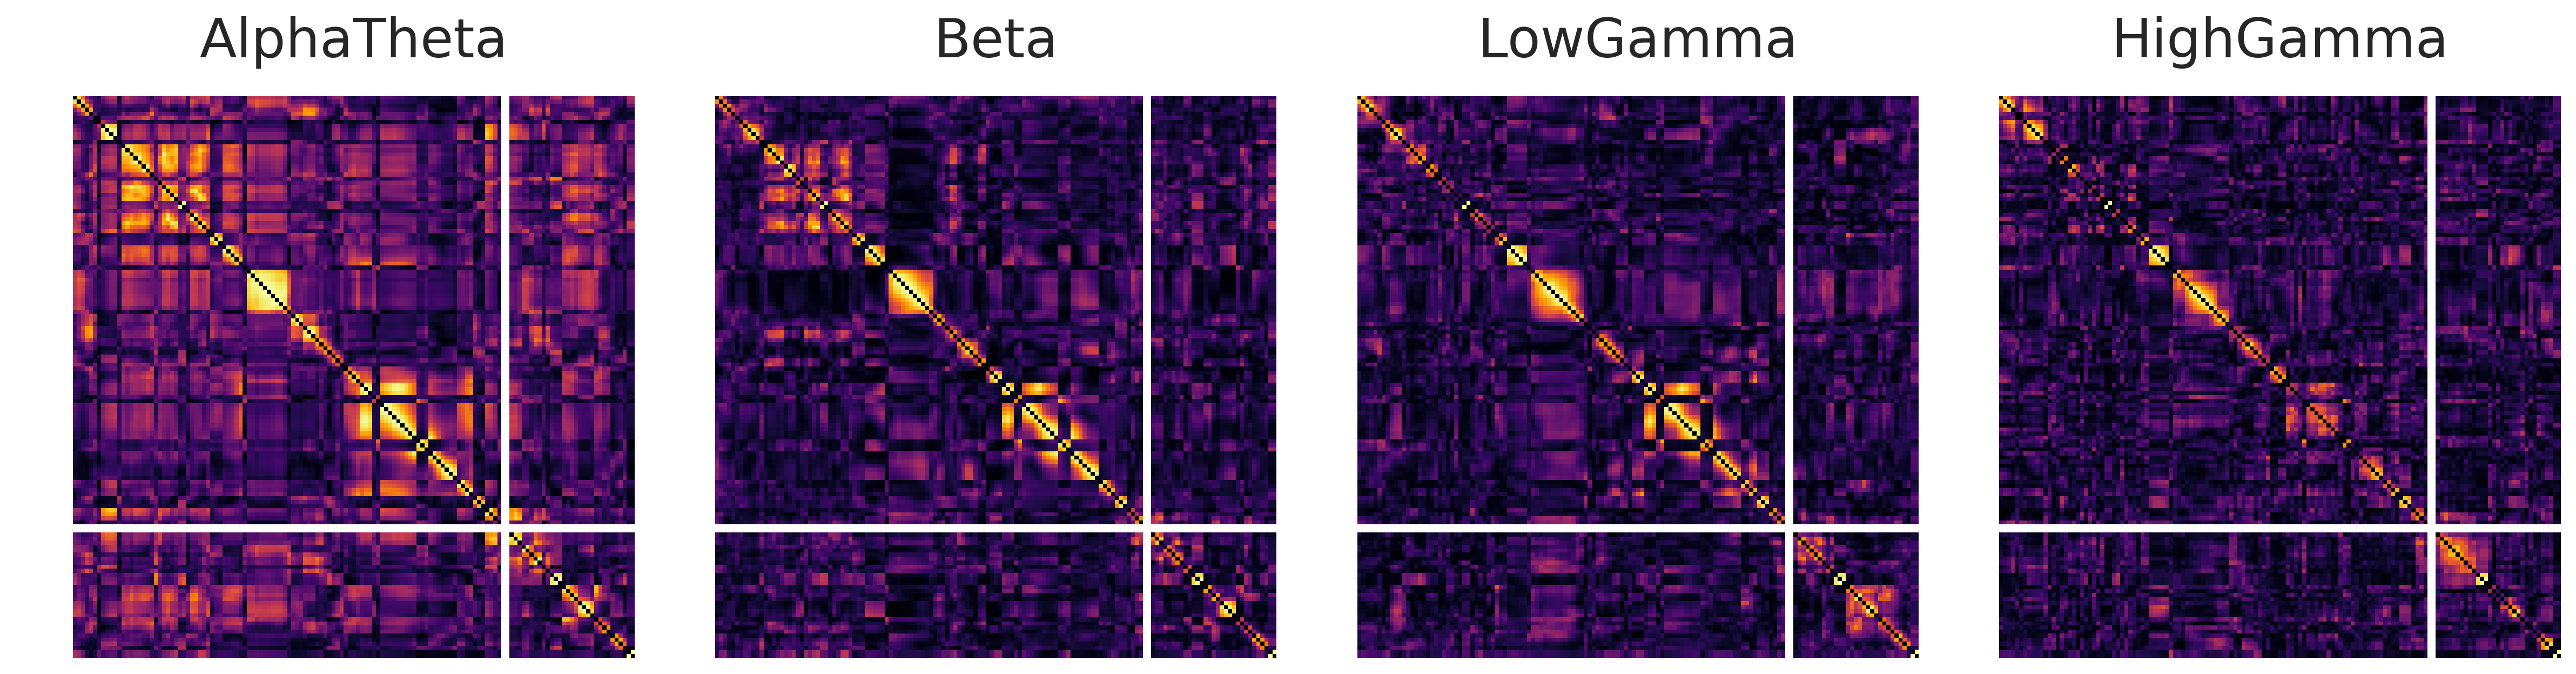

Delta Adjacency


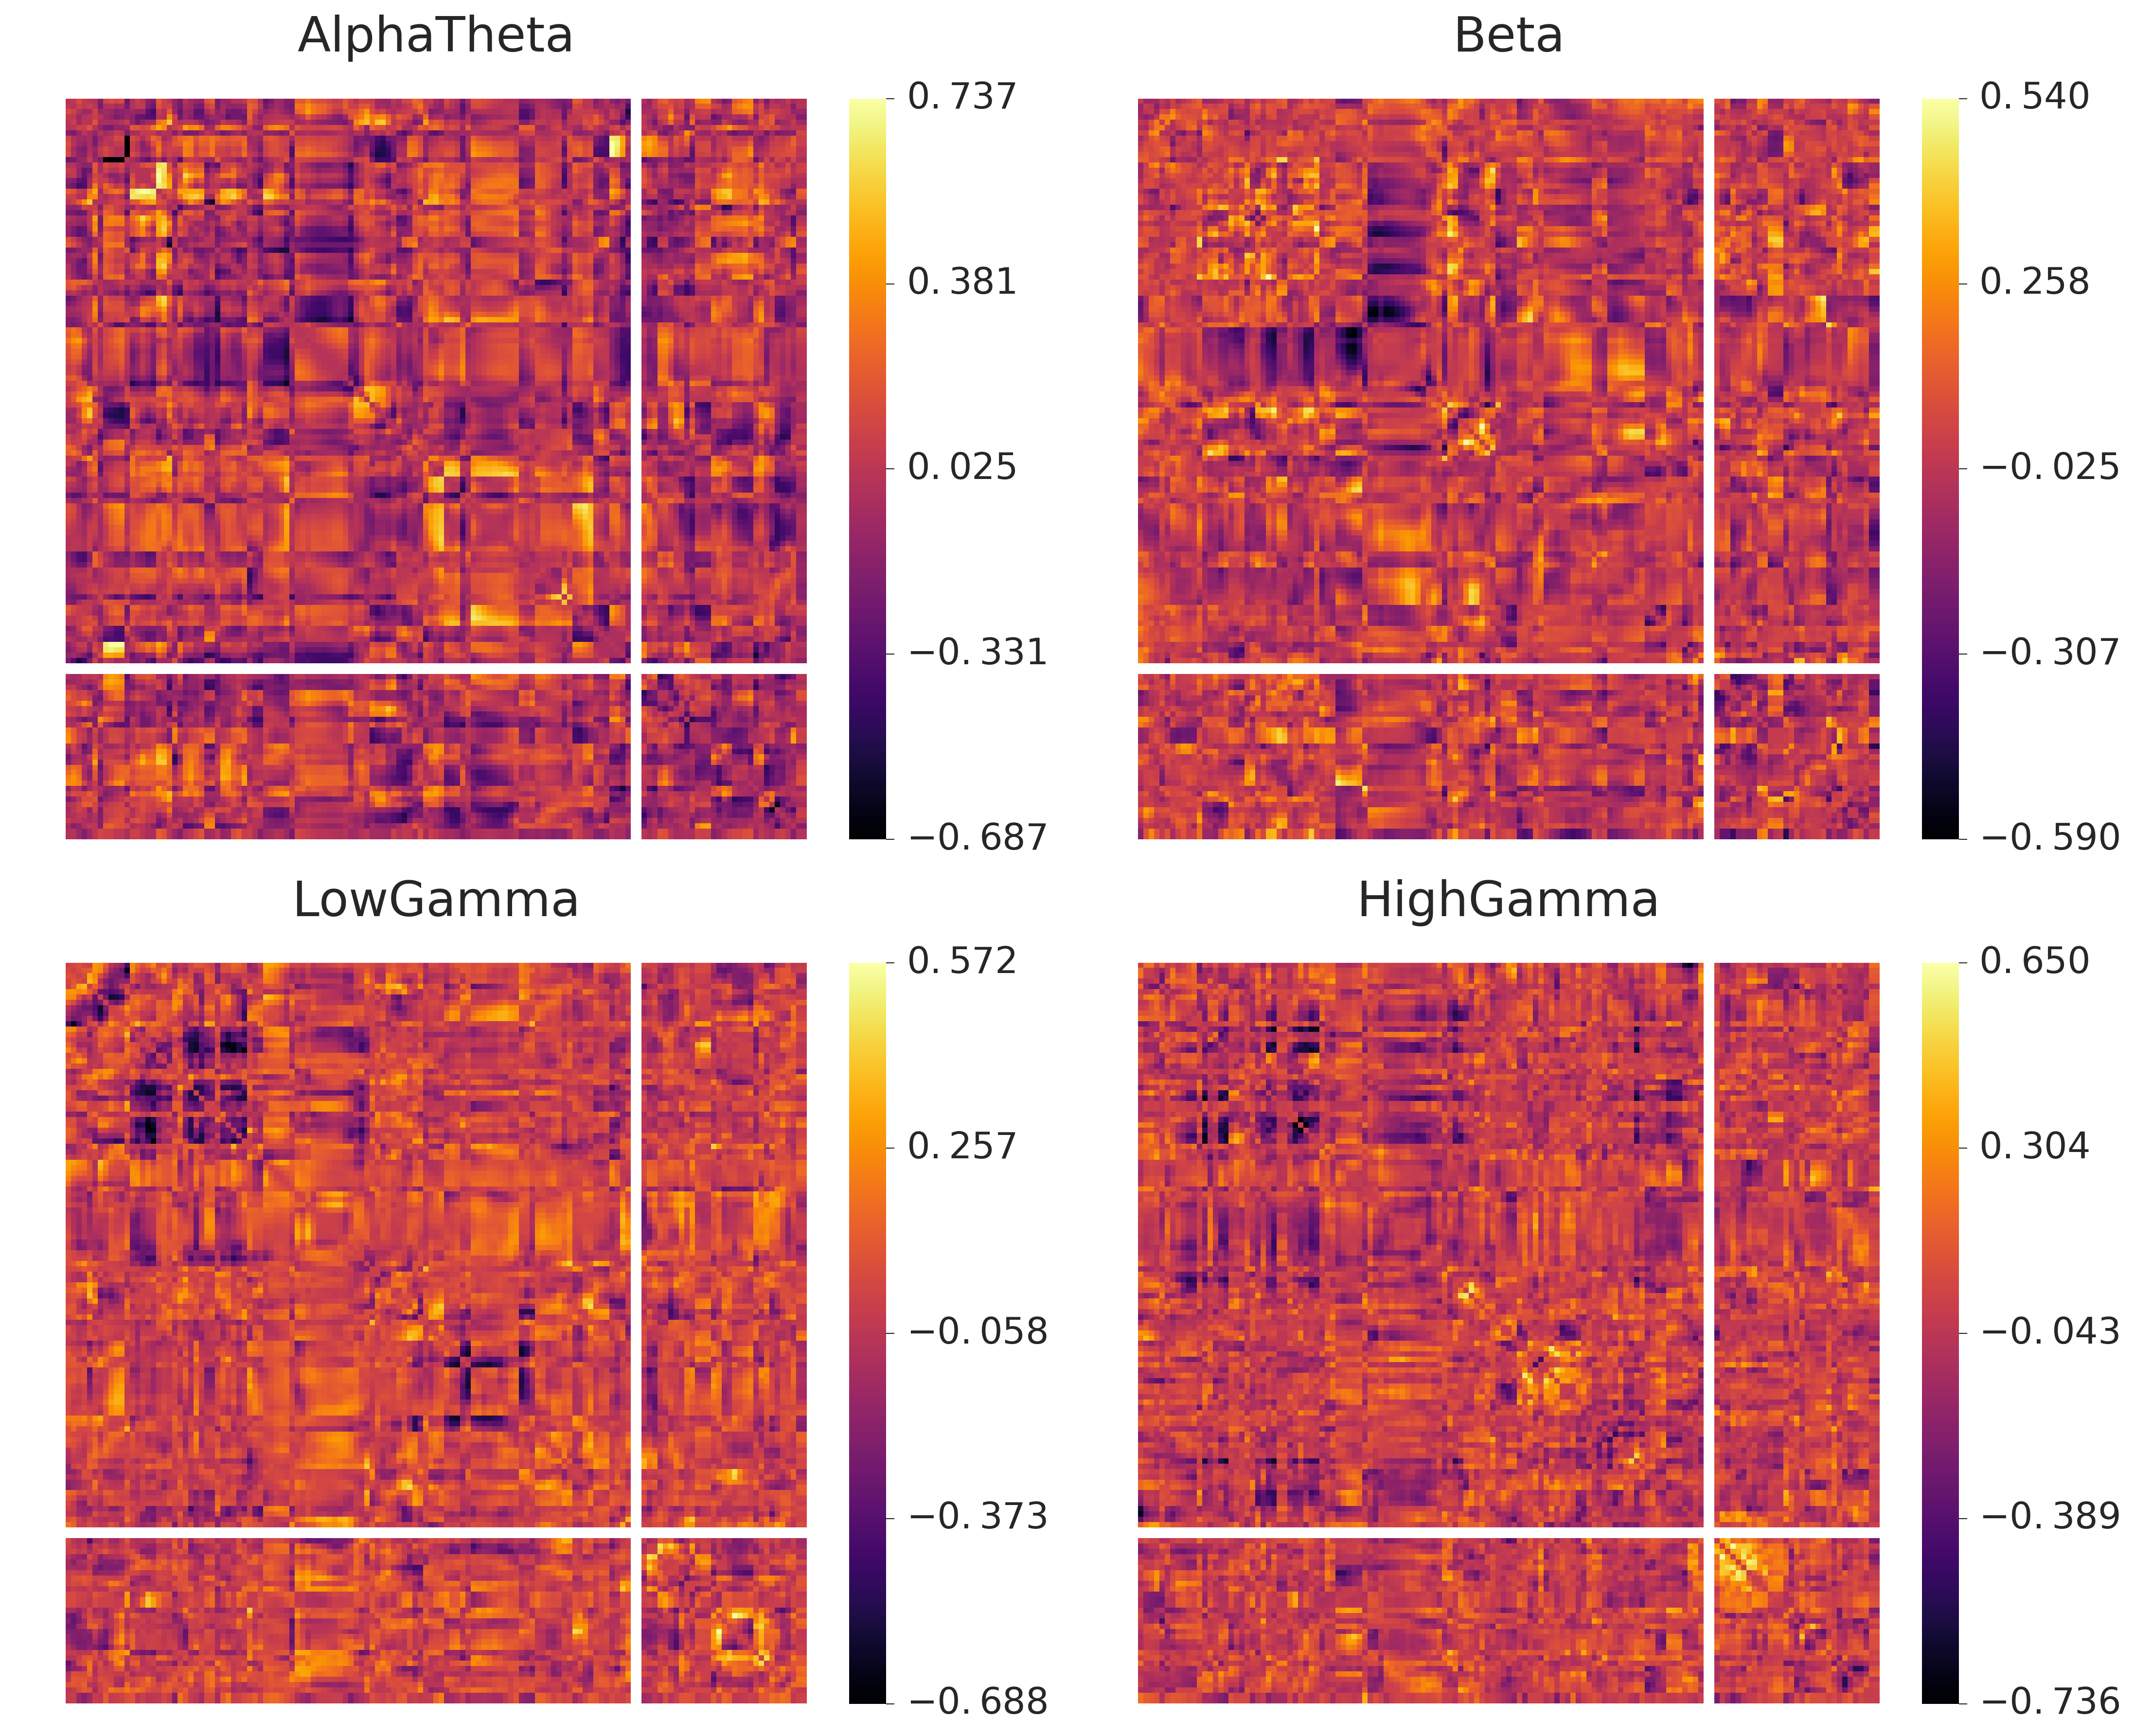

In [98]:
%matplotlib inline
#21909
sel_path = path_list[21950]
trial_name = sel_path.split('/')[-1]
stim_nodes = map(int, meta_dict[trial_name.split('.')[1]]['stim_nodes'])
print(trial_name)
print('Stim Nodes: {}'.format(stim_nodes))

# Check fin_items for a list of processed adjacency matrices
adj = np.load(sel_path)['adj'].item()

# Find Baseline
path_list_base = glob.glob('{}/Adjacency.{}.*.npz'.format(path_InpData_Baseline, sel_path.split('/')[-1].split('.')[1]))
adj_base = np.load(path_list_base[0])['adj'].item()

print('Baseline Adjacency')
plt.figure(figsize=(16, 12))
for ii, freq in enumerate(['AlphaTheta', 'Beta', 'LowGamma', 'HighGamma']):
    ax = plt.subplot(1,4,ii+1);
    
    adj_matr = adj_base['No_Stim'][freq]
    vmin, vmax = [0, 1]
    mat = ax.matshow(adj_matr, cmap='inferno', vmin=vmin, vmax=vmax); 
    
    #cb = plt.colorbar(mat, ax=ax, fraction=0.046, pad=0.04)
    #cb.set_ticks(np.linspace(vmin, vmax, 5))
    #cb.ax.tick_params(labelsize=18, width=0.5) 
    
    ax.set_title(freq)
    ax.set_axis_off();
plt.savefig('./e02-Figures/{}.Baseline.png'.format(trial_name))
plt.show()

print('Pre-Stimulus Adjacency')
plt.figure(figsize=(16, 12))
for ii, freq in enumerate(['AlphaTheta', 'Beta', 'LowGamma', 'HighGamma']):
    ax = plt.subplot(1,4,ii+1);
    
    adj_matr = adj['Pre_Stim'][freq]
    arr = np.insert(np.insert(adj_matr, [stim_nodes[0], stim_nodes[0]], np.nan, axis=0),
                    [stim_nodes[0], stim_nodes[0]], np.nan, axis=1)    
    vmin, vmax = [0, 1]
    mat = ax.matshow(arr, cmap='inferno', vmin=vmin, vmax=vmax); 
    
    #cb = plt.colorbar(mat, ax=ax, fraction=0.046, pad=0.04)
    #cb.set_ticks(np.linspace(vmin, vmax, 5))
    #cb.ax.tick_params(labelsize=18, width=0.5) 
    
    ax.set_title(freq)
    ax.set_axis_off();
plt.savefig('./e02-Figures/{}.PreStim.png'.format(trial_name))    
plt.show()

print('Post-Stimulus Adjacency')
plt.figure(figsize=(16, 12))
for ii, freq in enumerate(['AlphaTheta', 'Beta', 'LowGamma', 'HighGamma']):
    ax = plt.subplot(1,4,ii+1);
    
    adj_matr = adj['Post_Stim'][freq]
    arr = np.insert(np.insert(adj_matr, [stim_nodes[0], stim_nodes[0]], np.nan, axis=0),
                    [stim_nodes[0], stim_nodes[0]], np.nan, axis=1)    
    vmin, vmax = [0, 1]
    mat = ax.matshow(arr, cmap='inferno', vmin=vmin, vmax=vmax); 
    
    #cb = plt.colorbar(mat, ax=ax, fraction=0.046, pad=0.04)
    #cb.set_ticks(np.linspace(vmin, vmax, 5))
    #cb.ax.tick_params(labelsize=18, width=0.5) 
    
    ax.set_title(freq)
    ax.set_axis_off();
plt.savefig('./e02-Figures/{}.PostStim.png'.format(trial_name))    
plt.show()

print('Delta Adjacency')
plt.figure(figsize=(16, 12))
for ii, freq in enumerate(['AlphaTheta', 'Beta', 'LowGamma', 'HighGamma']):
    ax = plt.subplot(2,2,ii+1);
    
    adj_matr = adj['Post_Stim'][freq] - adj['Pre_Stim'][freq]
    arr = np.insert(np.insert(adj_matr, [stim_nodes[0], stim_nodes[0]], np.nan, axis=0),
                    [stim_nodes[0], stim_nodes[0]], np.nan, axis=1)    
    vmin, vmax = [adj_matr.min(), adj_matr.max()]
    mat = ax.matshow(arr, cmap='inferno', vmin=vmin, vmax=vmax); 
    
    cb = plt.colorbar(mat, ax=ax, fraction=0.046, pad=0.04)
    cb.set_ticks(np.linspace(vmin, vmax, 5))
    cb.ax.tick_params(labelsize=18, width=0.5) 
    
    ax.set_title(freq)
    ax.set_axis_off();
plt.savefig('./e02-Figures/{}.Delta.png'.format(trial_name))        
plt.show()